# mESC-Gene Phase

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 0.3145
Epoch 50/2000, Loss: 0.2033
Epoch 100/2000, Loss: 0.2000
Epoch 150/2000, Loss: 0.1968
Epoch 200/2000, Loss: 0.1936
Epoch 250/2000, Loss: 0.1906
Epoch 300/2000, Loss: 0.1882
Epoch 350/2000, Loss: 0.1867
Epoch 400/2000, Loss: 0.1850
Epoch 450/2000, Loss: 0.1839
Epoch 500/2000, Loss: 0.1824
Epoch 550/2000, Loss: 0.1812
Epoch 600/2000, Loss: 0.1800
Epoch 650/2000, Loss: 0.1789
Epoch 700/2000, Loss: 0.1778
Epoch 750/2000, Loss: 0.1770
Epoch 800/2000, Loss: 0.1761
Epoch 850/2000, Loss: 0.1757
Epoch 900/2000, Loss: 0.1747
Epoch 950/2000, Loss: 0.1742
Epoch 1000/2000, Loss: 0.1736
Epoch 1050/2000, Loss: 0.1730
Epoch 1100/2000, Loss: 0.1729
Epoch 1150/2000, Loss: 0.1722
Epoch 1200/2000, Loss: 0.1719
Epoch 1250/2000, Loss: 0.1718
Epoch 1300/2000, Loss: 0.1713
Epoch 1350/2000, Loss: 0.1705
Epoch 1400/2000, Loss: 0.1702
Epoch 1450/2000, Loss: 0.1701
Epoch 1500/2000, Loss: 0.1697
Epoch 1550/2000, Loss: 0.1691
Epoch 1600/2000, 

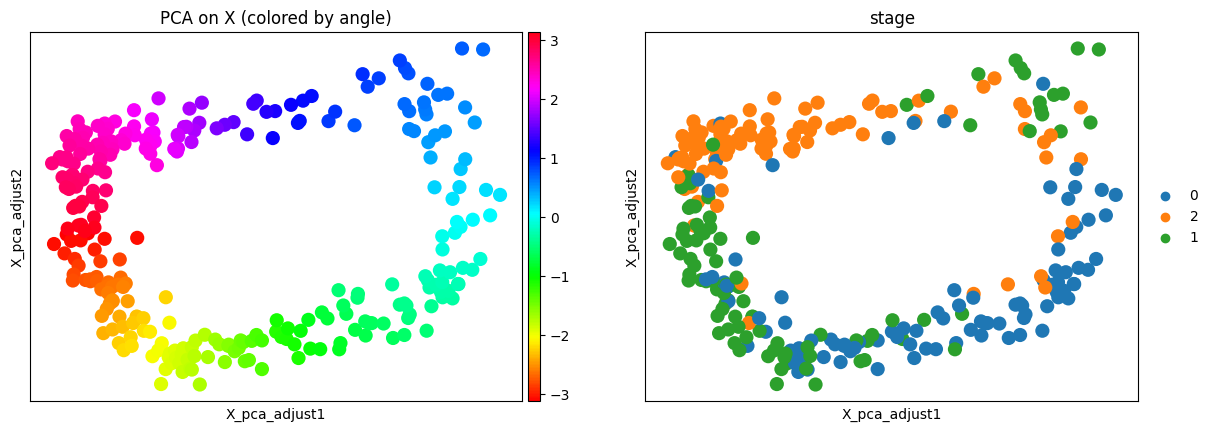

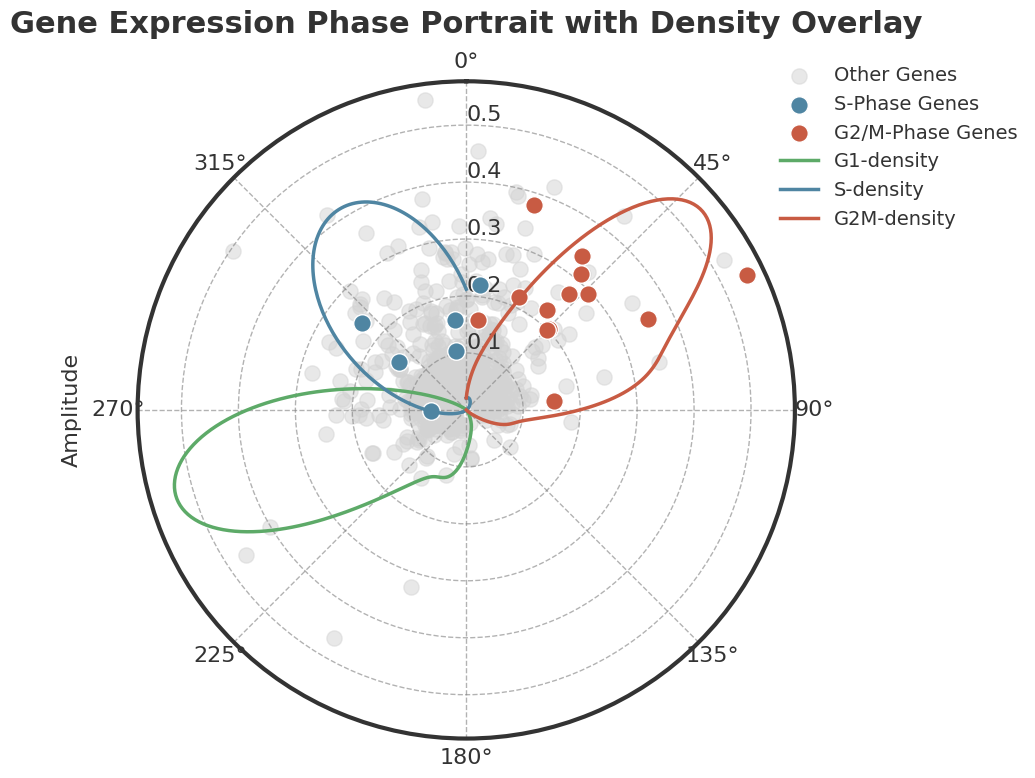

Plot saved to: ./FigurePlot/Gene_Radar/Radar_mESC.png


In [1]:
# --- Import required packages ---
import os
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Set working directory ---
# Change the current working directory to the project folder
os.chdir("/root/Cycle/Github")

# Print the current working directory to confirm
print("Current working directory:", os.getcwd())

# --- Add HarmoCycle module path ---
# Append the HarmoCycle module path so Python can find custom functions
sys.path.append("./HarmoCycle/")

# --- Import functions from HarmoCycle and Utils ---
from HarmoCycle import *
from Utils import set_seed, calculate_gene_oscillation_properties_v2

# --- Set random seed for reproducibility ---
set_seed(79710)

# --- Load dataset ---
adata1 = sc.read('./Dataset/mESC.h5ad')

# --- Preprocessing ---
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata1, target_sum=1e4)

# Apply log-transformation to stabilize variance
sc.pp.log1p(adata1)

# Shuffle cells randomly
adata1 = adata1[np.random.permutation(adata1.n_obs), :]

# --- Run HarmoCycle pipeline ---
_, _, adata_res1 = run_pipeline(
    adata1,
    epochs=2000,
    batch_size=1024,
    top_n_genes=5000,
    device='cuda:1'
)

# Sort cells by pseudo-angle
adata1 = adata1[adata1.obs['pseudo_angle'].sort_values().index, :]

# --- Extract periodic matrix ---
periodic_adata = get_periodic_matrix(adata1.copy(), top_k=10, use_highly_variable=True)

# --- Calculate PCA-based angle adjustment ---
adjust_adata1 = calculate_pca_angle(
    periodic_adata,
    use_rep='X',
    pca_key_added='X_pca_adjust',
    angle_key_added='pca_adjust_angle',
    plot=True
)

# Sort cells by adjusted PCA angle
adjust_adata1 = adjust_adata1[adjust_adata1.obs.sort_values(by='pca_adjust_angle').index, :]

# --- Calculate gene oscillation properties ---
adjust_adata1 = calculate_gene_oscillation_properties_v2(adjust_adata1)
adata1 = adjust_adata1.copy()

# --- Select dominant frequency bin and sort genes by amplitude ---
adata1 = adata1[:, adata1.var['dominant_frequency_bin'].isin(
    adata1.var['dominant_frequency_bin'].value_counts().index[:1]
)]
adata1 = adata1[:, adata1.var.sort_values('dominant_amplitude', ascending=False).index]

# Keep top 1000 genes
temp_res = adata1.var.head(1000).copy()
temp_res.sort_values('dominant_phase_deg', ascending=False, inplace=True)

# --- Load S-phase and G2/M-phase gene lists ---
s_genes = pd.read_table('./Dataset/Seurat_s_genes.csv')['x'].values
g2m_genes = pd.read_table('./Dataset/Seurat_g2m_genes.csv')['x'].values

# Filter genes present in temp_res
s_genes_in_temp_res = [gene for gene in s_genes if gene in temp_res.index]
g2m_genes_in_temp_res = [gene for gene in g2m_genes if gene in temp_res.index]

# --- Step 1: Compute median expression per stage ---
# Stage labels: 0 = G1, 1 = S, 2 = G2M
stage_labels = adata1.obs['stage']
stage_matrix = pd.DataFrame(adata1.X.toarray(), columns=adata1.var_names, index=adata1.obs_names)

stage_means = {
    'G1': stage_matrix[stage_labels == 0].median(axis=0),
    'S': stage_matrix[stage_labels == 1].median(axis=0),
    'G2M': stage_matrix[stage_labels == 2].median(axis=0),
}
stage_means_df = pd.DataFrame(stage_means)

# --- Step 2: Assign dominant stage with threshold ---
min_margin = 0.2  # Threshold: top stage must exceed second stage by at least 20%

def get_dominant_stage_with_threshold(row):
    sorted_vals = row.sort_values(ascending=False)
    top1 = sorted_vals.iloc[0]
    top2 = sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

stage_means_df['dominant_stage'] = stage_means_df.apply(get_dominant_stage_with_threshold, axis=1)

# --- Define colors for visualization ---
color_g1 = "#5DAA68"   # Green for G1 phase
color_s = "#4F85A2"    # Blue for S phase
color_g2m = "#C85B43"  # Red for G2/M phase
color_other = "#D3D3D3" # Grey for other genes
color_text = "#333333" # Dark text color

# --- Compute mean expression per stage ---
mean_expr = {
    'G1': stage_matrix[stage_labels == 0].mean(axis=0),
    'S': stage_matrix[stage_labels == 1].mean(axis=0),
    'G2M': stage_matrix[stage_labels == 2].mean(axis=0),
}
mean_expr_df = pd.DataFrame(mean_expr)

# Assign dominant stage with margin
def get_dominant_stage_with_margin(row):
    sorted_vals = row.sort_values(ascending=False)
    top1, top2 = sorted_vals.iloc[0], sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

mean_expr_df['dominant_stage'] = mean_expr_df.apply(get_dominant_stage_with_margin, axis=1)

# Merge dominant stage info into temp_res
temp_res['dominant_stage'] = mean_expr_df.loc[temp_res.index, 'dominant_stage']

# --- Convert dominant phase degrees to radians ---
def get_phase_radians(stage_name):
    degrees = temp_res[temp_res['dominant_stage'] == stage_name]['dominant_phase_deg'].values
    return np.deg2rad(degrees)

# Extract radians for each stage
g1_radians = get_phase_radians('G1')
s_radians = get_phase_radians('S')
g2m_radians = get_phase_radians('G2M')

# --- Kernel Density Estimation (KDE) ---
def smooth_density(data, num_points=512):
    if len(data) < 2:
        return np.linspace(0, 2*np.pi, num_points), np.zeros(num_points)
    kde = gaussian_kde(data, bw_method='scott')
    theta = np.linspace(0, 2*np.pi, num_points)
    density = kde(theta)
    return theta, density

theta_g1, density_g1 = smooth_density(g1_radians)
theta_s, density_s = smooth_density(s_radians)
theta_g2m, density_g2m = smooth_density(g2m_radians)

# --- Create polar plot ---
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# --- Scatter plot of gene phases and amplitudes ---
all_phases_deg = temp_res['dominant_phase_deg']
all_amplitudes = temp_res['dominant_amplitude']
s_data = temp_res.loc[s_genes_in_temp_res]
g2m_data = temp_res.loc[g2m_genes_in_temp_res]

all_phases_rad = np.deg2rad(all_phases_deg)
s_phases_rad = np.deg2rad(s_data['dominant_phase_deg'])
s_amplitudes = s_data['dominant_amplitude']
g2m_phases_rad = np.deg2rad(g2m_data['dominant_phase_deg'])
g2m_amplitudes = g2m_data['dominant_amplitude']

# Plot other genes
ax.scatter(all_phases_rad, all_amplitudes, c=color_other, alpha=0.5, s=120, label='Other Genes', zorder=1)

# Plot S-phase genes
ax.scatter(s_phases_rad, s_amplitudes, c=color_s, s=160, ec='w', lw=1.0, label='S-Phase Genes', zorder=3)

# Plot G2/M-phase genes
ax.scatter(g2m_phases_rad, g2m_amplitudes, c=color_g2m, s=160, ec='w', lw=1.0, label='G2/M-Phase Genes', zorder=3)

# --- Plot KDE density curves ---
ax.plot(theta_g1, density_g1 * max(all_amplitudes), color=color_g1, lw=2.5, label='G1-density', zorder=5)
ax.plot(theta_s, density_s * max(all_amplitudes), color=color_s, lw=2.5, label='S-density', zorder=5)
ax.plot(theta_g2m, density_g2m * max(all_amplitudes), color=color_g2m, lw=2.5, label='G2M-density', zorder=5)

# --- Finalize polar plot aesthetics ---
# Set the zero angle (0°) at the top (North)
ax.set_theta_zero_location('N')

# Set the direction of increasing angles clockwise
ax.set_theta_direction(-1)

# Add plot title
ax.set_title(
    'Gene Expression Phase Portrait with Density Overlay',
    fontsize=22,
    weight='bold',
    pad=35,
    color=color_text
)

# Adjust radial labels
ax.set_rlabel_position(0)
ax.tick_params(axis='y', labelsize=16, colors=color_text)
ax.tick_params(axis='x', labelsize=16, colors=color_text)

# Add radial axis label
ax.set_ylabel(
    'Amplitude',
    fontsize=16,
    labelpad=40,
    color=color_text,
    weight='medium'
)

# Customize polar spine
ax.spines['polar'].set_edgecolor(color_text)
ax.spines['polar'].set_linewidth(3)

# Add gridlines
ax.grid(True, linestyle='--', color='grey', alpha=0.6, linewidth=1)

# --- Add legend ---
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.95, 1.05),
    fontsize=14,
    frameon=False
)
for text in legend.get_texts():
    text.set_color(color_text)

# --- Save plot ---
# Define save path
save_path = './FigurePlot/Gene_Radar/Radar_mESC.png'

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure with high resolution
plt.tight_layout(pad=1.5)
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

# Print confirmation message
print(f"Plot saved to: {save_path}")



# hESC-Gene Phase

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 0.4440
Epoch 50/2000, Loss: 0.2197
Epoch 100/2000, Loss: 0.2161
Epoch 150/2000, Loss: 0.2129
Epoch 200/2000, Loss: 0.2100
Epoch 250/2000, Loss: 0.2074
Epoch 300/2000, Loss: 0.2052
Epoch 350/2000, Loss: 0.2038
Epoch 400/2000, Loss: 0.2021
Epoch 450/2000, Loss: 0.2008
Epoch 500/2000, Loss: 0.1992
Epoch 550/2000, Loss: 0.1978
Epoch 600/2000, Loss: 0.1968
Epoch 650/2000, Loss: 0.1955
Epoch 700/2000, Loss: 0.1947
Epoch 750/2000, Loss: 0.1937
Epoch 800/2000, Loss: 0.1930
Epoch 850/2000, Loss: 0.1921
Epoch 900/2000, Loss: 0.1914
Epoch 950/2000, Loss: 0.1908
Epoch 1000/2000, Loss: 0.1902
Epoch 1050/2000, Loss: 0.1896
Epoch 1100/2000, Loss: 0.1890
Epoch 1150/2000, Loss: 0.1886
Epoch 1200/2000, Loss: 0.1881
Epoch 1250/2000, Loss: 0.1874
Epoch 1300/2000, Loss: 0.1871
Epoch 1350/2000, Loss: 0.1864
Epoch 1400/2000, Loss: 0.1859
Epoch 1450/2000, Loss: 0.1855
Epoch 1500/2000, Loss: 0.1849
Epoch 1550/2000, Loss: 0.1849
Epoch 1600/2000, 

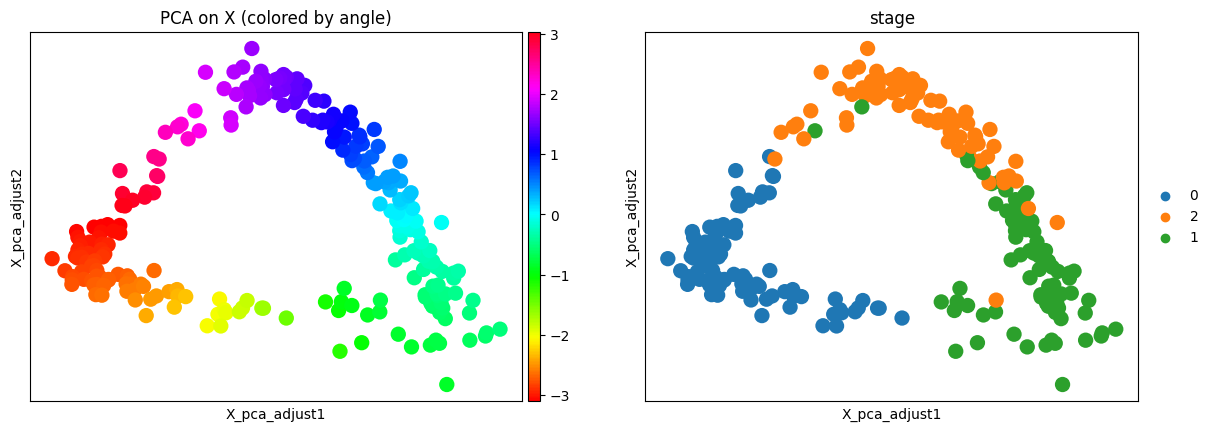

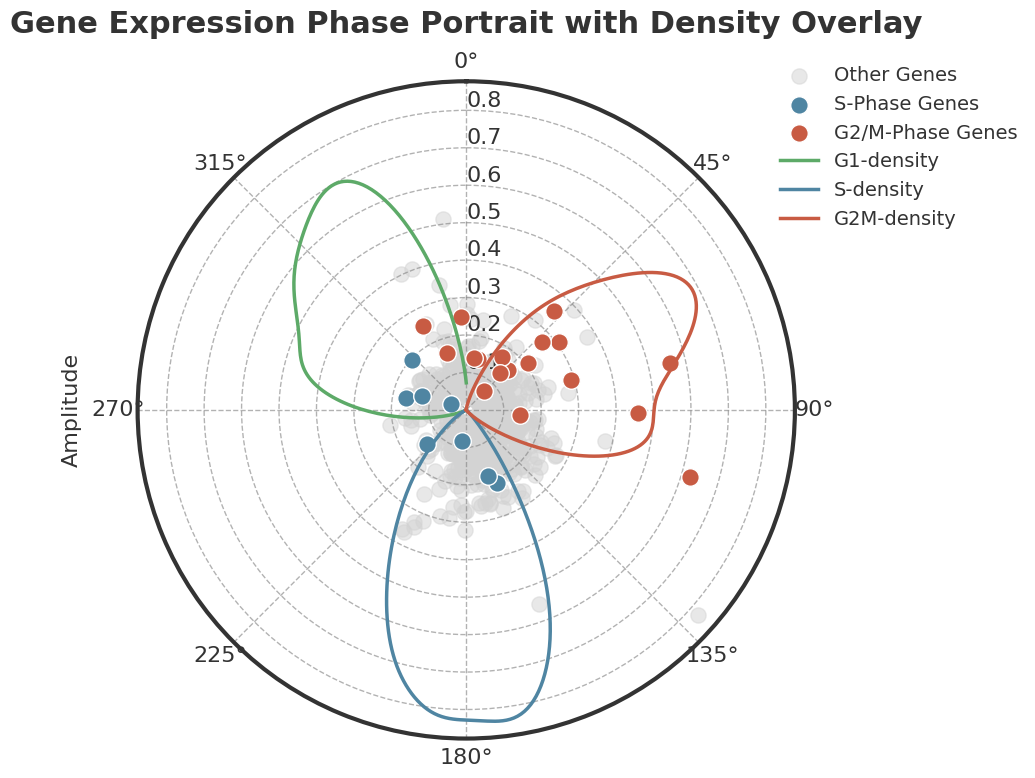

Plot saved to: ./FigurePlot/Gene_Radar/Radar_hESC.png


In [2]:
# --- Import required packages ---
import os
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Set working directory ---
# Change the current working directory to the project folder
os.chdir("/root/Cycle/Github")

# Print the current working directory to confirm
print("Current working directory:", os.getcwd())

# --- Add HarmoCycle module path ---
# Append the HarmoCycle module path so Python can find custom functions
sys.path.append("./HarmoCycle/")

# --- Import functions from HarmoCycle and Utils ---
from HarmoCycle import *
from Utils import set_seed, calculate_gene_oscillation_properties_v2

# --- Set random seed for reproducibility ---
set_seed(79710)

# --- Load dataset ---
adata1 = sc.read('./Dataset/hESC.h5ad')

# --- Preprocessing ---
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata1, target_sum=1e4)

# Apply log-transformation to stabilize variance
sc.pp.log1p(adata1)

# Shuffle cells randomly
adata1 = adata1[np.random.permutation(adata1.n_obs), :]

# --- Run HarmoCycle pipeline ---
_, _, adata_res1 = run_pipeline(
    adata1,
    epochs=2000,
    batch_size=1024,
    top_n_genes=5000,
    device='cuda:1'
)

# Sort cells by pseudo-angle
adata1 = adata1[adata1.obs['pseudo_angle'].sort_values().index, :]

# --- Extract periodic matrix ---
periodic_adata = get_periodic_matrix(adata1.copy(), top_k=10, use_highly_variable=True)

# --- Calculate PCA-based angle adjustment ---
adjust_adata1 = calculate_pca_angle(
    periodic_adata,
    use_rep='X',
    pca_key_added='X_pca_adjust',
    angle_key_added='pca_adjust_angle',
    plot=True
)

# Sort cells by adjusted PCA angle
adjust_adata1 = adjust_adata1[adjust_adata1.obs.sort_values(by='pca_adjust_angle').index, :]

# --- Calculate gene oscillation properties ---
adjust_adata1 = calculate_gene_oscillation_properties_v2(adjust_adata1)
adata1 = adjust_adata1.copy()

# --- Select dominant frequency bin and sort genes by amplitude ---
adata1 = adata1[:, adata1.var['dominant_frequency_bin'].isin(
    adata1.var['dominant_frequency_bin'].value_counts().index[:1]
)]
adata1 = adata1[:, adata1.var.sort_values('dominant_amplitude', ascending=False).index]

# Keep top 1000 genes
temp_res = adata1.var.head(1000).copy()
temp_res.sort_values('dominant_phase_deg', ascending=False, inplace=True)

# --- Load S-phase and G2/M-phase gene lists ---
s_genes = pd.read_table('./Dataset/Seurat_s_genes.csv')['x'].values
g2m_genes = pd.read_table('./Dataset/Seurat_g2m_genes.csv')['x'].values

# Filter genes present in temp_res
s_genes_in_temp_res = [gene for gene in s_genes if gene in temp_res.index]
g2m_genes_in_temp_res = [gene for gene in g2m_genes if gene in temp_res.index]

# --- Step 1: Compute median expression per stage ---
# Stage labels: 0 = G1, 1 = S, 2 = G2M
stage_labels = adata1.obs['stage']
stage_matrix = pd.DataFrame(adata1.X.toarray(), columns=adata1.var_names, index=adata1.obs_names)

stage_means = {
    'G1': stage_matrix[stage_labels == 0].median(axis=0),
    'S': stage_matrix[stage_labels == 1].median(axis=0),
    'G2M': stage_matrix[stage_labels == 2].median(axis=0),
}
stage_means_df = pd.DataFrame(stage_means)

# --- Step 2: Assign dominant stage with threshold ---
min_margin = 0.2  # Threshold: top stage must exceed second stage by at least 20%

def get_dominant_stage_with_threshold(row):
    sorted_vals = row.sort_values(ascending=False)
    top1 = sorted_vals.iloc[0]
    top2 = sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

stage_means_df['dominant_stage'] = stage_means_df.apply(get_dominant_stage_with_threshold, axis=1)

# --- Define colors for visualization ---
color_g1 = "#5DAA68"   # Green for G1 phase
color_s = "#4F85A2"    # Blue for S phase
color_g2m = "#C85B43"  # Red for G2/M phase
color_other = "#D3D3D3" # Grey for other genes
color_text = "#333333" # Dark text color

# --- Compute mean expression per stage ---
mean_expr = {
    'G1': stage_matrix[stage_labels == 0].mean(axis=0),
    'S': stage_matrix[stage_labels == 1].mean(axis=0),
    'G2M': stage_matrix[stage_labels == 2].mean(axis=0),
}
mean_expr_df = pd.DataFrame(mean_expr)

# Assign dominant stage with margin
def get_dominant_stage_with_margin(row):
    sorted_vals = row.sort_values(ascending=False)
    top1, top2 = sorted_vals.iloc[0], sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

mean_expr_df['dominant_stage'] = mean_expr_df.apply(get_dominant_stage_with_margin, axis=1)

# Merge dominant stage info into temp_res
temp_res['dominant_stage'] = mean_expr_df.loc[temp_res.index, 'dominant_stage']

# --- Convert dominant phase degrees to radians ---
def get_phase_radians(stage_name):
    degrees = temp_res[temp_res['dominant_stage'] == stage_name]['dominant_phase_deg'].values
    return np.deg2rad(degrees)

# Extract radians for each stage
g1_radians = get_phase_radians('G1')
s_radians = get_phase_radians('S')
g2m_radians = get_phase_radians('G2M')

# --- Kernel Density Estimation (KDE) ---
def smooth_density(data, num_points=512):
    if len(data) < 2:
        return np.linspace(0, 2*np.pi, num_points), np.zeros(num_points)
    kde = gaussian_kde(data, bw_method='scott')
    theta = np.linspace(0, 2*np.pi, num_points)
    density = kde(theta)
    return theta, density

theta_g1, density_g1 = smooth_density(g1_radians)
theta_s, density_s = smooth_density(s_radians)
theta_g2m, density_g2m = smooth_density(g2m_radians)

# --- Create polar plot ---
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# --- Scatter plot of gene phases and amplitudes ---
all_phases_deg = temp_res['dominant_phase_deg']
all_amplitudes = temp_res['dominant_amplitude']
s_data = temp_res.loc[s_genes_in_temp_res]
g2m_data = temp_res.loc[g2m_genes_in_temp_res]

all_phases_rad = np.deg2rad(all_phases_deg)
s_phases_rad = np.deg2rad(s_data['dominant_phase_deg'])
s_amplitudes = s_data['dominant_amplitude']
g2m_phases_rad = np.deg2rad(g2m_data['dominant_phase_deg'])
g2m_amplitudes = g2m_data['dominant_amplitude']

# Plot other genes
ax.scatter(all_phases_rad, all_amplitudes, c=color_other, alpha=0.5, s=120, label='Other Genes', zorder=1)

# Plot S-phase genes
ax.scatter(s_phases_rad, s_amplitudes, c=color_s, s=160, ec='w', lw=1.0, label='S-Phase Genes', zorder=3)

# Plot G2/M-phase genes
ax.scatter(g2m_phases_rad, g2m_amplitudes, c=color_g2m, s=160, ec='w', lw=1.0, label='G2/M-Phase Genes', zorder=3)

# --- Plot KDE density curves ---
ax.plot(theta_g1, density_g1 * max(all_amplitudes), color=color_g1, lw=2.5, label='G1-density', zorder=5)
ax.plot(theta_s, density_s * max(all_amplitudes), color=color_s, lw=2.5, label='S-density', zorder=5)
ax.plot(theta_g2m, density_g2m * max(all_amplitudes), color=color_g2m, lw=2.5, label='G2M-density', zorder=5)

# --- Finalize polar plot aesthetics ---
# Set the zero angle (0°) at the top (North)
ax.set_theta_zero_location('N')

# Set the direction of increasing angles clockwise
ax.set_theta_direction(-1)

# Add plot title
ax.set_title(
    'Gene Expression Phase Portrait with Density Overlay',
    fontsize=22,
    weight='bold',
    pad=35,
    color=color_text
)

# Adjust radial labels
ax.set_rlabel_position(0)
ax.tick_params(axis='y', labelsize=16, colors=color_text)
ax.tick_params(axis='x', labelsize=16, colors=color_text)

# Add radial axis label
ax.set_ylabel(
    'Amplitude',
    fontsize=16,
    labelpad=40,
    color=color_text,
    weight='medium'
)

# Customize polar spine
ax.spines['polar'].set_edgecolor(color_text)
ax.spines['polar'].set_linewidth(3)

# Add gridlines
ax.grid(True, linestyle='--', color='grey', alpha=0.6, linewidth=1)

# --- Add legend ---
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.95, 1.05),
    fontsize=14,
    frameon=False
)
for text in legend.get_texts():
    text.set_color(color_text)

# --- Save plot ---
# Define save path
save_path = './FigurePlot/Gene_Radar/Radar_hESC.png'

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure with high resolution
plt.tight_layout(pad=1.5)
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

# Print confirmation message
print(f"Plot saved to: {save_path}")



# hU2OS-Gene Phase

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 0.3488
Epoch 50/2000, Loss: 0.1887
Epoch 100/2000, Loss: 0.1874
Epoch 150/2000, Loss: 0.1876
Epoch 200/2000, Loss: 0.1853
Epoch 250/2000, Loss: 0.1849
Epoch 300/2000, Loss: 0.1856
Epoch 350/2000, Loss: 0.1846
Epoch 400/2000, Loss: 0.1850
Epoch 450/2000, Loss: 0.1843
Epoch 500/2000, Loss: 0.1849
Epoch 550/2000, Loss: 0.1844
Epoch 600/2000, Loss: 0.1840
Epoch 650/2000, Loss: 0.1846
Epoch 700/2000, Loss: 0.1823
Epoch 750/2000, Loss: 0.1844
Epoch 800/2000, Loss: 0.1842
Epoch 850/2000, Loss: 0.1835
Epoch 900/2000, Loss: 0.1842
Epoch 950/2000, Loss: 0.1834
Epoch 1000/2000, Loss: 0.1838
Epoch 1050/2000, Loss: 0.1835
Epoch 1100/2000, Loss: 0.1833
Epoch 1150/2000, Loss: 0.1833
Epoch 1200/2000, Loss: 0.1826
Epoch 1250/2000, Loss: 0.1810
Epoch 1300/2000, Loss: 0.1820
Epoch 1350/2000, Loss: 0.1809
Epoch 1400/2000, Loss: 0.1824
Epoch 1450/2000, Loss: 0.1839
Epoch 1500/2000, Loss: 0.1832
Epoch 1550/2000, Loss: 0.1808
Epoch 1600/2000, 

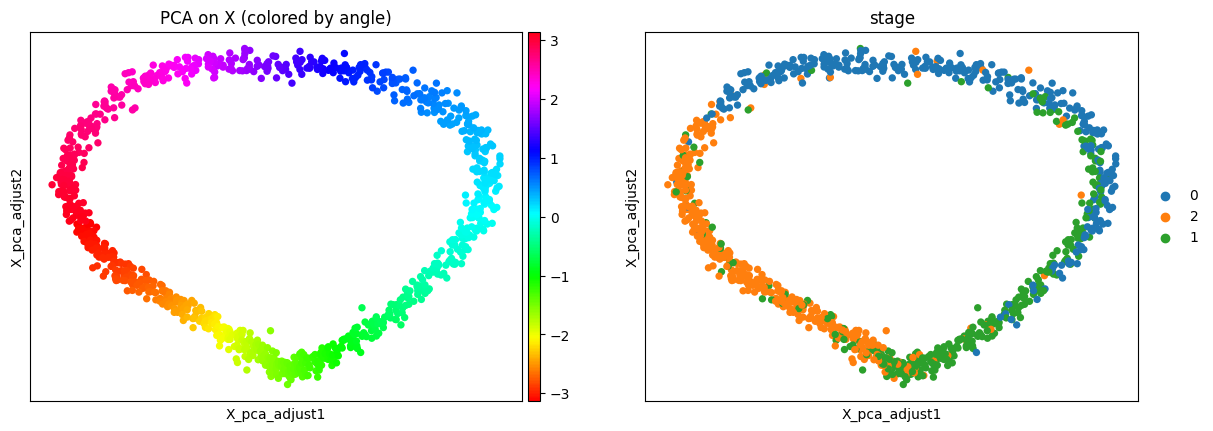

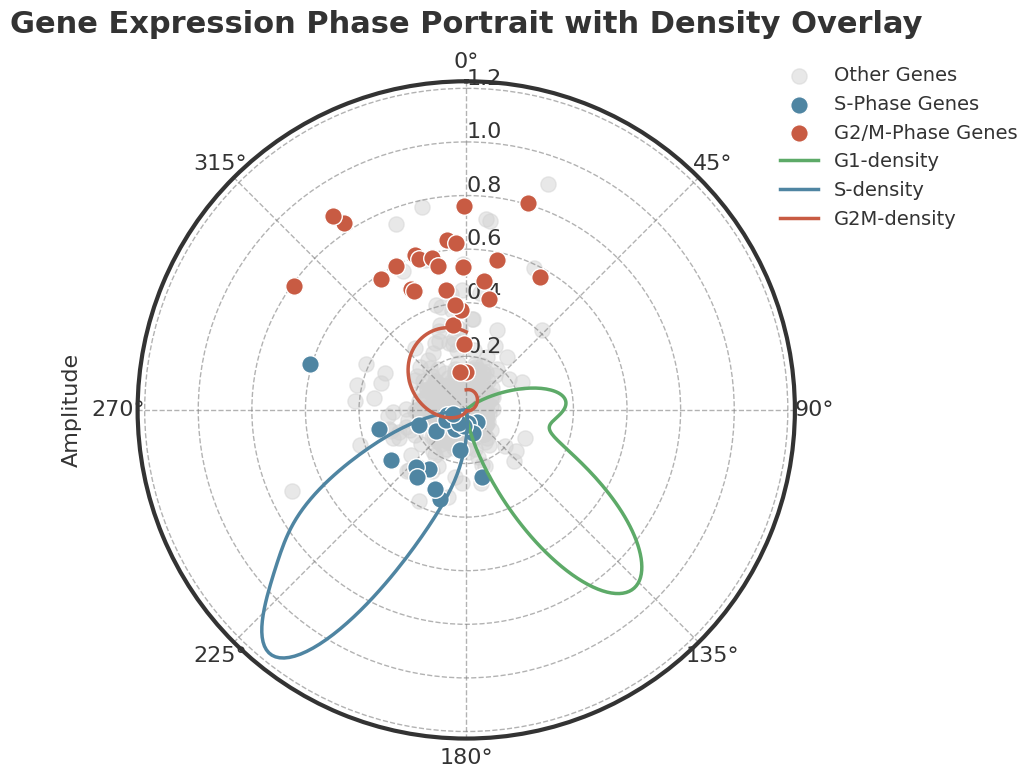

Plot saved to: ./FigurePlot/Gene_Radar/Radar_hU2OS.png


In [3]:
# --- Import required packages ---
import os
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Set working directory ---
# Change the current working directory to the project folder
os.chdir("/root/Cycle/Github")

# Print the current working directory to confirm
print("Current working directory:", os.getcwd())

# --- Add HarmoCycle module path ---
# Append the HarmoCycle module path so Python can find custom functions
sys.path.append("./HarmoCycle/")

# --- Import functions from HarmoCycle and Utils ---
from HarmoCycle import *
from Utils import set_seed, calculate_gene_oscillation_properties_v2

# --- Set random seed for reproducibility ---
set_seed(79710)

# --- Load dataset ---
adata1 = sc.read('./Dataset/hU2OS.h5ad')

# --- Preprocessing ---
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata1, target_sum=1e4)

# Apply log-transformation to stabilize variance
sc.pp.log1p(adata1)

# Shuffle cells randomly
adata1 = adata1[np.random.permutation(adata1.n_obs), :]

# --- Run HarmoCycle pipeline ---
_, _, adata_res1 = run_pipeline(
    adata1,
    epochs=2000,
    batch_size=1024,
    top_n_genes=5000,
    device='cuda:1'
)

# Sort cells by pseudo-angle
adata1 = adata1[adata1.obs['pseudo_angle'].sort_values().index, :]

# --- Extract periodic matrix ---
periodic_adata = get_periodic_matrix(adata1.copy(), top_k=10, use_highly_variable=True)

# --- Calculate PCA-based angle adjustment ---
adjust_adata1 = calculate_pca_angle(
    periodic_adata,
    use_rep='X',
    pca_key_added='X_pca_adjust',
    angle_key_added='pca_adjust_angle',
    plot=True
)

# Sort cells by adjusted PCA angle
adjust_adata1 = adjust_adata1[adjust_adata1.obs.sort_values(by='pca_adjust_angle').index, :]

# --- Calculate gene oscillation properties ---
adjust_adata1 = calculate_gene_oscillation_properties_v2(adjust_adata1)
adata1 = adjust_adata1.copy()

# --- Select dominant frequency bin and sort genes by amplitude ---
adata1 = adata1[:, adata1.var['dominant_frequency_bin'].isin(
    adata1.var['dominant_frequency_bin'].value_counts().index[:1]
)]
adata1 = adata1[:, adata1.var.sort_values('dominant_amplitude', ascending=False).index]

# Keep top 1000 genes
temp_res = adata1.var.head(1000).copy()
temp_res.sort_values('dominant_phase_deg', ascending=False, inplace=True)

# --- Load S-phase and G2/M-phase gene lists ---
s_genes = pd.read_table('./Dataset/Seurat_s_genes.csv')['x'].values
g2m_genes = pd.read_table('./Dataset/Seurat_g2m_genes.csv')['x'].values

# Filter genes present in temp_res
s_genes_in_temp_res = [gene for gene in s_genes if gene in temp_res.index]
g2m_genes_in_temp_res = [gene for gene in g2m_genes if gene in temp_res.index]

# --- Step 1: Compute median expression per stage ---
# Stage labels: 0 = G1, 1 = S, 2 = G2M
stage_labels = adata1.obs['stage']
stage_matrix = pd.DataFrame(adata1.X.toarray(), columns=adata1.var_names, index=adata1.obs_names)

stage_means = {
    'G1': stage_matrix[stage_labels == 0].median(axis=0),
    'S': stage_matrix[stage_labels == 1].median(axis=0),
    'G2M': stage_matrix[stage_labels == 2].median(axis=0),
}
stage_means_df = pd.DataFrame(stage_means)

# --- Step 2: Assign dominant stage with threshold ---
min_margin = 0.2  # Threshold: top stage must exceed second stage by at least 20%

def get_dominant_stage_with_threshold(row):
    sorted_vals = row.sort_values(ascending=False)
    top1 = sorted_vals.iloc[0]
    top2 = sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

stage_means_df['dominant_stage'] = stage_means_df.apply(get_dominant_stage_with_threshold, axis=1)

# --- Define colors for visualization ---
color_g1 = "#5DAA68"   # Green for G1 phase
color_s = "#4F85A2"    # Blue for S phase
color_g2m = "#C85B43"  # Red for G2/M phase
color_other = "#D3D3D3" # Grey for other genes
color_text = "#333333" # Dark text color

# --- Compute mean expression per stage ---
mean_expr = {
    'G1': stage_matrix[stage_labels == 0].mean(axis=0),
    'S': stage_matrix[stage_labels == 1].mean(axis=0),
    'G2M': stage_matrix[stage_labels == 2].mean(axis=0),
}
mean_expr_df = pd.DataFrame(mean_expr)

# Assign dominant stage with margin
def get_dominant_stage_with_margin(row):
    sorted_vals = row.sort_values(ascending=False)
    top1, top2 = sorted_vals.iloc[0], sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

mean_expr_df['dominant_stage'] = mean_expr_df.apply(get_dominant_stage_with_margin, axis=1)

# Merge dominant stage info into temp_res
temp_res['dominant_stage'] = mean_expr_df.loc[temp_res.index, 'dominant_stage']

# --- Convert dominant phase degrees to radians ---
def get_phase_radians(stage_name):
    degrees = temp_res[temp_res['dominant_stage'] == stage_name]['dominant_phase_deg'].values
    return np.deg2rad(degrees)

# Extract radians for each stage
g1_radians = get_phase_radians('G1')
s_radians = get_phase_radians('S')
g2m_radians = get_phase_radians('G2M')

# --- Kernel Density Estimation (KDE) ---
def smooth_density(data, num_points=512):
    if len(data) < 2:
        return np.linspace(0, 2*np.pi, num_points), np.zeros(num_points)
    kde = gaussian_kde(data, bw_method='scott')
    theta = np.linspace(0, 2*np.pi, num_points)
    density = kde(theta)
    return theta, density

theta_g1, density_g1 = smooth_density(g1_radians)
theta_s, density_s = smooth_density(s_radians)
theta_g2m, density_g2m = smooth_density(g2m_radians)

# --- Create polar plot ---
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# --- Scatter plot of gene phases and amplitudes ---
all_phases_deg = temp_res['dominant_phase_deg']
all_amplitudes = temp_res['dominant_amplitude']
s_data = temp_res.loc[s_genes_in_temp_res]
g2m_data = temp_res.loc[g2m_genes_in_temp_res]

all_phases_rad = np.deg2rad(all_phases_deg)
s_phases_rad = np.deg2rad(s_data['dominant_phase_deg'])
s_amplitudes = s_data['dominant_amplitude']
g2m_phases_rad = np.deg2rad(g2m_data['dominant_phase_deg'])
g2m_amplitudes = g2m_data['dominant_amplitude']

# Plot other genes
ax.scatter(all_phases_rad, all_amplitudes, c=color_other, alpha=0.5, s=120, label='Other Genes', zorder=1)

# Plot S-phase genes
ax.scatter(s_phases_rad, s_amplitudes, c=color_s, s=160, ec='w', lw=1.0, label='S-Phase Genes', zorder=3)

# Plot G2/M-phase genes
ax.scatter(g2m_phases_rad, g2m_amplitudes, c=color_g2m, s=160, ec='w', lw=1.0, label='G2/M-Phase Genes', zorder=3)

# --- Plot KDE density curves ---
ax.plot(theta_g1, density_g1 * max(all_amplitudes), color=color_g1, lw=2.5, label='G1-density', zorder=5)
ax.plot(theta_s, density_s * max(all_amplitudes), color=color_s, lw=2.5, label='S-density', zorder=5)
ax.plot(theta_g2m, density_g2m * max(all_amplitudes), color=color_g2m, lw=2.5, label='G2M-density', zorder=5)

# --- Finalize polar plot aesthetics ---
# Set the zero angle (0°) at the top (North)
ax.set_theta_zero_location('N')

# Set the direction of increasing angles clockwise
ax.set_theta_direction(-1)

# Add plot title
ax.set_title(
    'Gene Expression Phase Portrait with Density Overlay',
    fontsize=22,
    weight='bold',
    pad=35,
    color=color_text
)

# Adjust radial labels
ax.set_rlabel_position(0)
ax.tick_params(axis='y', labelsize=16, colors=color_text)
ax.tick_params(axis='x', labelsize=16, colors=color_text)

# Add radial axis label
ax.set_ylabel(
    'Amplitude',
    fontsize=16,
    labelpad=40,
    color=color_text,
    weight='medium'
)

# Customize polar spine
ax.spines['polar'].set_edgecolor(color_text)
ax.spines['polar'].set_linewidth(3)

# Add gridlines
ax.grid(True, linestyle='--', color='grey', alpha=0.6, linewidth=1)

# --- Add legend ---
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.95, 1.05),
    fontsize=14,
    frameon=False
)
for text in legend.get_texts():
    text.set_color(color_text)

# --- Save plot ---
# Define save path
save_path = './FigurePlot/Gene_Radar/Radar_hU2OS.png'

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure with high resolution
plt.tight_layout(pad=1.5)
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

# Print confirmation message
print(f"Plot saved to: {save_path}")



# mESCQ-Gene Phase

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 0.3900
Epoch 50/2000, Loss: 0.1966
Epoch 100/2000, Loss: 0.1906
Epoch 150/2000, Loss: 0.1849
Epoch 200/2000, Loss: 0.1790
Epoch 250/2000, Loss: 0.1754
Epoch 300/2000, Loss: 0.1727
Epoch 350/2000, Loss: 0.1698
Epoch 400/2000, Loss: 0.1679
Epoch 450/2000, Loss: 0.1660
Epoch 500/2000, Loss: 0.1647
Epoch 550/2000, Loss: 0.1636
Epoch 600/2000, Loss: 0.1637
Epoch 650/2000, Loss: 0.1635
Epoch 700/2000, Loss: 0.1629
Epoch 750/2000, Loss: 0.1630
Epoch 800/2000, Loss: 0.1629
Epoch 850/2000, Loss: 0.1630
Epoch 900/2000, Loss: 0.1628
Epoch 950/2000, Loss: 0.1629
Epoch 1000/2000, Loss: 0.1627
Epoch 1050/2000, Loss: 0.1629
Epoch 1100/2000, Loss: 0.1628
Epoch 1150/2000, Loss: 0.1628
Epoch 1200/2000, Loss: 0.1627
Epoch 1250/2000, Loss: 0.1628
Epoch 1300/2000, Loss: 0.1629
Epoch 1350/2000, Loss: 0.1628
Epoch 1400/2000, Loss: 0.1627
Epoch 1450/2000, Loss: 0.1628
Epoch 1500/2000, Loss: 0.1627
Epoch 1550/2000, Loss: 0.1626
Epoch 1600/2000, 

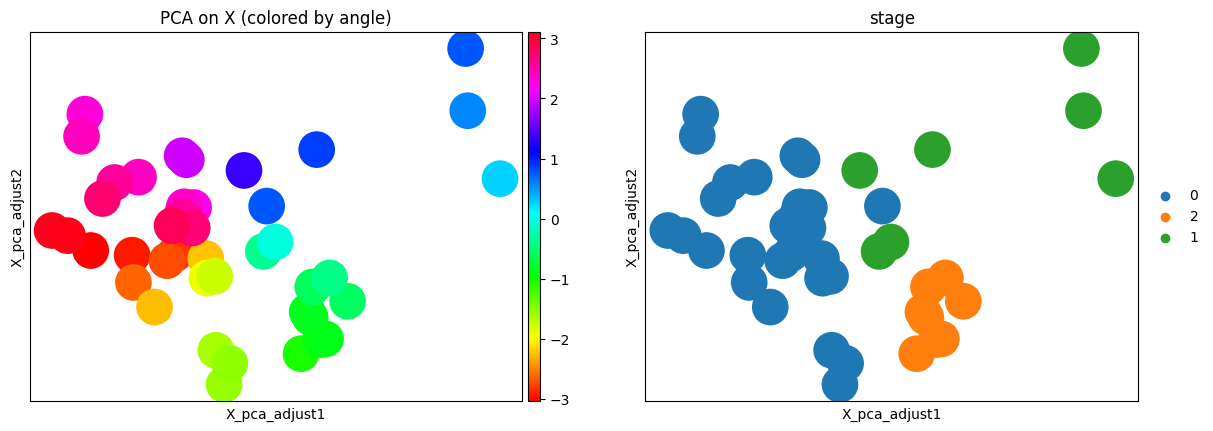

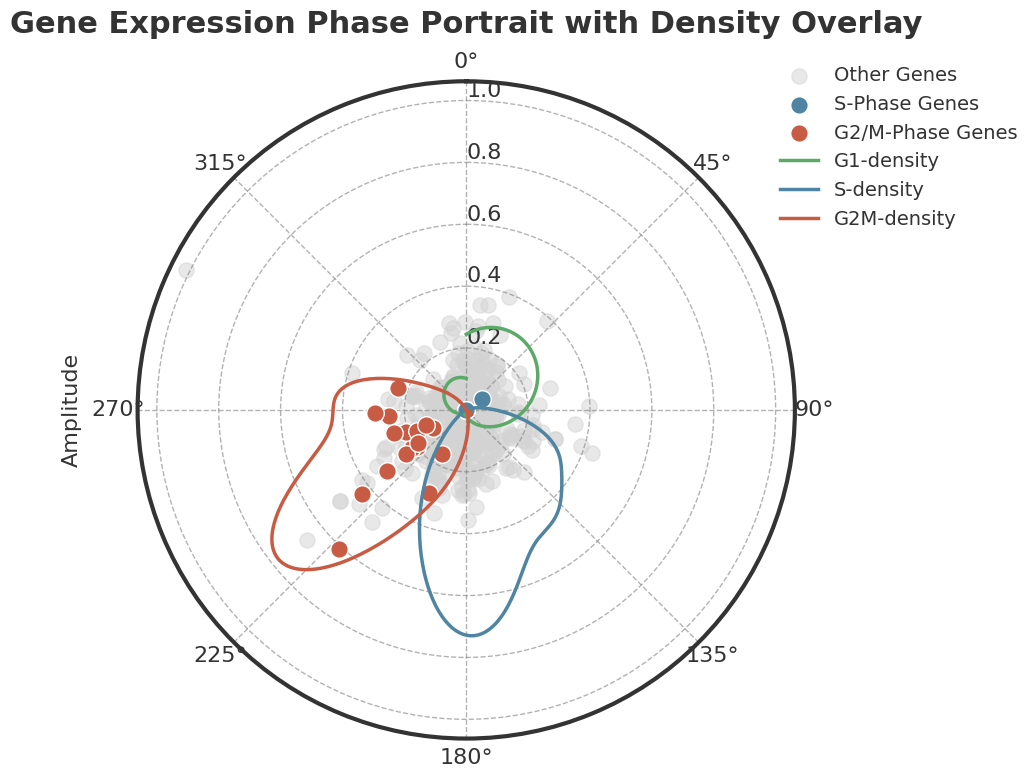

Plot saved to: ./FigurePlot/Gene_Radar/Radar_mESCQ.png


In [4]:
# --- Import required packages ---
import os
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Set working directory ---
# Change the current working directory to the project folder
os.chdir("/root/Cycle/Github")

# Print the current working directory to confirm
print("Current working directory:", os.getcwd())

# --- Add HarmoCycle module path ---
# Append the HarmoCycle module path so Python can find custom functions
sys.path.append("./HarmoCycle/")

# --- Import functions from HarmoCycle and Utils ---
from HarmoCycle import *
from Utils import set_seed, calculate_gene_oscillation_properties_v2

# --- Set random seed for reproducibility ---
set_seed(79710)

# --- Load dataset ---
adata1 = sc.read('./Dataset/mESCQ.h5ad')

# --- Preprocessing ---
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata1, target_sum=1e4)

# Apply log-transformation to stabilize variance
sc.pp.log1p(adata1)

# Shuffle cells randomly
adata1 = adata1[np.random.permutation(adata1.n_obs), :]

# --- Run HarmoCycle pipeline ---
_, _, adata_res1 = run_pipeline(
    adata1,
    epochs=2000,
    batch_size=1024,
    top_n_genes=5000,
    device='cuda:1'
)

# Sort cells by pseudo-angle
adata1 = adata1[adata1.obs['pseudo_angle'].sort_values().index, :]

# --- Extract periodic matrix ---
periodic_adata = get_periodic_matrix(adata1.copy(), top_k=10, use_highly_variable=True)

# --- Calculate PCA-based angle adjustment ---
adjust_adata1 = calculate_pca_angle(
    periodic_adata,
    use_rep='X',
    pca_key_added='X_pca_adjust',
    angle_key_added='pca_adjust_angle',
    plot=True
)

# Sort cells by adjusted PCA angle
adjust_adata1 = adjust_adata1[adjust_adata1.obs.sort_values(by='pca_adjust_angle').index, :]

# --- Calculate gene oscillation properties ---
adjust_adata1 = calculate_gene_oscillation_properties_v2(adjust_adata1)
adata1 = adjust_adata1.copy()

# --- Select dominant frequency bin and sort genes by amplitude ---
adata1 = adata1[:, adata1.var['dominant_frequency_bin'].isin(
    adata1.var['dominant_frequency_bin'].value_counts().index[:1]
)]
adata1 = adata1[:, adata1.var.sort_values('dominant_amplitude', ascending=False).index]

# Keep top 1000 genes
temp_res = adata1.var.head(1000).copy()
temp_res.sort_values('dominant_phase_deg', ascending=False, inplace=True)

# --- Load S-phase and G2/M-phase gene lists ---
s_genes = pd.read_table('./Dataset/Seurat_s_genes.csv')['x'].values
g2m_genes = pd.read_table('./Dataset/Seurat_g2m_genes.csv')['x'].values

# Filter genes present in temp_res
s_genes_in_temp_res = [gene for gene in s_genes if gene in temp_res.index]
g2m_genes_in_temp_res = [gene for gene in g2m_genes if gene in temp_res.index]

# --- Step 1: Compute median expression per stage ---
# Stage labels: 0 = G1, 1 = S, 2 = G2M
stage_labels = adata1.obs['stage']
stage_matrix = pd.DataFrame(adata1.X.toarray(), columns=adata1.var_names, index=adata1.obs_names)

stage_means = {
    'G1': stage_matrix[stage_labels == 0].median(axis=0),
    'S': stage_matrix[stage_labels == 1].median(axis=0),
    'G2M': stage_matrix[stage_labels == 2].median(axis=0),
}
stage_means_df = pd.DataFrame(stage_means)

# --- Step 2: Assign dominant stage with threshold ---
min_margin = 0.2  # Threshold: top stage must exceed second stage by at least 20%

def get_dominant_stage_with_threshold(row):
    sorted_vals = row.sort_values(ascending=False)
    top1 = sorted_vals.iloc[0]
    top2 = sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

stage_means_df['dominant_stage'] = stage_means_df.apply(get_dominant_stage_with_threshold, axis=1)

# --- Define colors for visualization ---
color_g1 = "#5DAA68"   # Green for G1 phase
color_s = "#4F85A2"    # Blue for S phase
color_g2m = "#C85B43"  # Red for G2/M phase
color_other = "#D3D3D3" # Grey for other genes
color_text = "#333333" # Dark text color

# --- Compute mean expression per stage ---
mean_expr = {
    'G1': stage_matrix[stage_labels == 0].mean(axis=0),
    'S': stage_matrix[stage_labels == 1].mean(axis=0),
    'G2M': stage_matrix[stage_labels == 2].mean(axis=0),
}
mean_expr_df = pd.DataFrame(mean_expr)

# Assign dominant stage with margin
def get_dominant_stage_with_margin(row):
    sorted_vals = row.sort_values(ascending=False)
    top1, top2 = sorted_vals.iloc[0], sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

mean_expr_df['dominant_stage'] = mean_expr_df.apply(get_dominant_stage_with_margin, axis=1)

# Merge dominant stage info into temp_res
temp_res['dominant_stage'] = mean_expr_df.loc[temp_res.index, 'dominant_stage']

# --- Convert dominant phase degrees to radians ---
def get_phase_radians(stage_name):
    degrees = temp_res[temp_res['dominant_stage'] == stage_name]['dominant_phase_deg'].values
    return np.deg2rad(degrees)

# Extract radians for each stage
g1_radians = get_phase_radians('G1')
s_radians = get_phase_radians('S')
g2m_radians = get_phase_radians('G2M')

# --- Kernel Density Estimation (KDE) ---
def smooth_density(data, num_points=512):
    if len(data) < 2:
        return np.linspace(0, 2*np.pi, num_points), np.zeros(num_points)
    kde = gaussian_kde(data, bw_method='scott')
    theta = np.linspace(0, 2*np.pi, num_points)
    density = kde(theta)
    return theta, density

theta_g1, density_g1 = smooth_density(g1_radians)
theta_s, density_s = smooth_density(s_radians)
theta_g2m, density_g2m = smooth_density(g2m_radians)

# --- Create polar plot ---
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# --- Scatter plot of gene phases and amplitudes ---
all_phases_deg = temp_res['dominant_phase_deg']
all_amplitudes = temp_res['dominant_amplitude']
s_data = temp_res.loc[s_genes_in_temp_res]
g2m_data = temp_res.loc[g2m_genes_in_temp_res]

all_phases_rad = np.deg2rad(all_phases_deg)
s_phases_rad = np.deg2rad(s_data['dominant_phase_deg'])
s_amplitudes = s_data['dominant_amplitude']
g2m_phases_rad = np.deg2rad(g2m_data['dominant_phase_deg'])
g2m_amplitudes = g2m_data['dominant_amplitude']

# Plot other genes
ax.scatter(all_phases_rad, all_amplitudes, c=color_other, alpha=0.5, s=120, label='Other Genes', zorder=1)

# Plot S-phase genes
ax.scatter(s_phases_rad, s_amplitudes, c=color_s, s=160, ec='w', lw=1.0, label='S-Phase Genes', zorder=3)

# Plot G2/M-phase genes
ax.scatter(g2m_phases_rad, g2m_amplitudes, c=color_g2m, s=160, ec='w', lw=1.0, label='G2/M-Phase Genes', zorder=3)

# --- Plot KDE density curves ---
ax.plot(theta_g1, density_g1 * max(all_amplitudes), color=color_g1, lw=2.5, label='G1-density', zorder=5)
ax.plot(theta_s, density_s * max(all_amplitudes), color=color_s, lw=2.5, label='S-density', zorder=5)
ax.plot(theta_g2m, density_g2m * max(all_amplitudes), color=color_g2m, lw=2.5, label='G2M-density', zorder=5)

# --- Finalize polar plot aesthetics ---
# Set the zero angle (0°) at the top (North)
ax.set_theta_zero_location('N')

# Set the direction of increasing angles clockwise
ax.set_theta_direction(-1)

# Add plot title
ax.set_title(
    'Gene Expression Phase Portrait with Density Overlay',
    fontsize=22,
    weight='bold',
    pad=35,
    color=color_text
)

# Adjust radial labels
ax.set_rlabel_position(0)
ax.tick_params(axis='y', labelsize=16, colors=color_text)
ax.tick_params(axis='x', labelsize=16, colors=color_text)

# Add radial axis label
ax.set_ylabel(
    'Amplitude',
    fontsize=16,
    labelpad=40,
    color=color_text,
    weight='medium'
)

# Customize polar spine
ax.spines['polar'].set_edgecolor(color_text)
ax.spines['polar'].set_linewidth(3)

# Add gridlines
ax.grid(True, linestyle='--', color='grey', alpha=0.6, linewidth=1)

# --- Add legend ---
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.95, 1.05),
    fontsize=14,
    frameon=False
)
for text in legend.get_texts():
    text.set_color(color_text)

# --- Save plot ---
# Define save path
save_path = './FigurePlot/Gene_Radar/Radar_mESCQ.png'

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure with high resolution
plt.tight_layout(pad=1.5)
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

# Print confirmation message
print(f"Plot saved to: {save_path}")



# mESC-Gene Phase Random

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 0.3145
Epoch 50/2000, Loss: 0.2033
Epoch 100/2000, Loss: 0.2000
Epoch 150/2000, Loss: 0.1968
Epoch 200/2000, Loss: 0.1936
Epoch 250/2000, Loss: 0.1906
Epoch 300/2000, Loss: 0.1882
Epoch 350/2000, Loss: 0.1867
Epoch 400/2000, Loss: 0.1850
Epoch 450/2000, Loss: 0.1839
Epoch 500/2000, Loss: 0.1824
Epoch 550/2000, Loss: 0.1812
Epoch 600/2000, Loss: 0.1800
Epoch 650/2000, Loss: 0.1789
Epoch 700/2000, Loss: 0.1778
Epoch 750/2000, Loss: 0.1770
Epoch 800/2000, Loss: 0.1761
Epoch 850/2000, Loss: 0.1757
Epoch 900/2000, Loss: 0.1747
Epoch 950/2000, Loss: 0.1742
Epoch 1000/2000, Loss: 0.1736
Epoch 1050/2000, Loss: 0.1730
Epoch 1100/2000, Loss: 0.1729
Epoch 1150/2000, Loss: 0.1722
Epoch 1200/2000, Loss: 0.1719
Epoch 1250/2000, Loss: 0.1718
Epoch 1300/2000, Loss: 0.1713
Epoch 1350/2000, Loss: 0.1705
Epoch 1400/2000, Loss: 0.1702
Epoch 1450/2000, Loss: 0.1701
Epoch 1500/2000, Loss: 0.1697
Epoch 1550/2000, Loss: 0.1691
Epoch 1600/2000, 

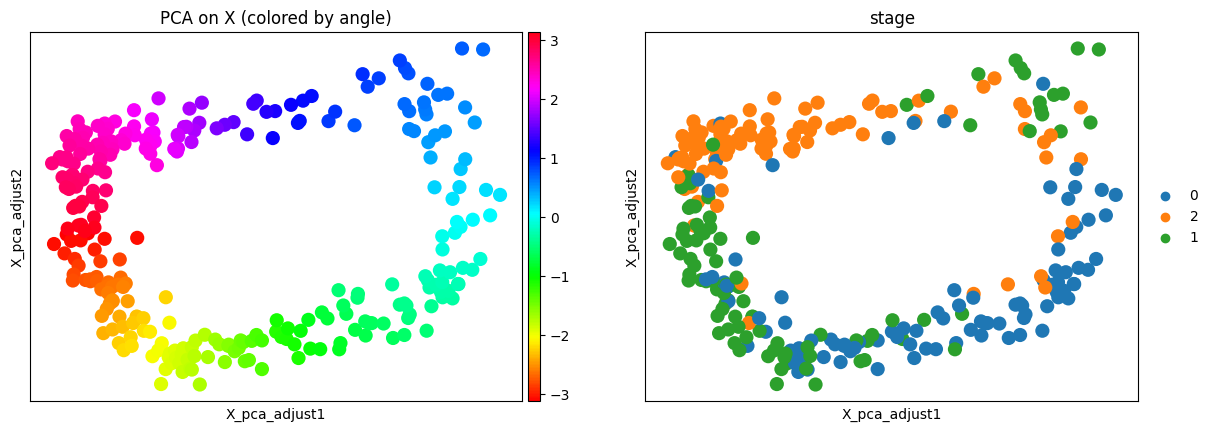

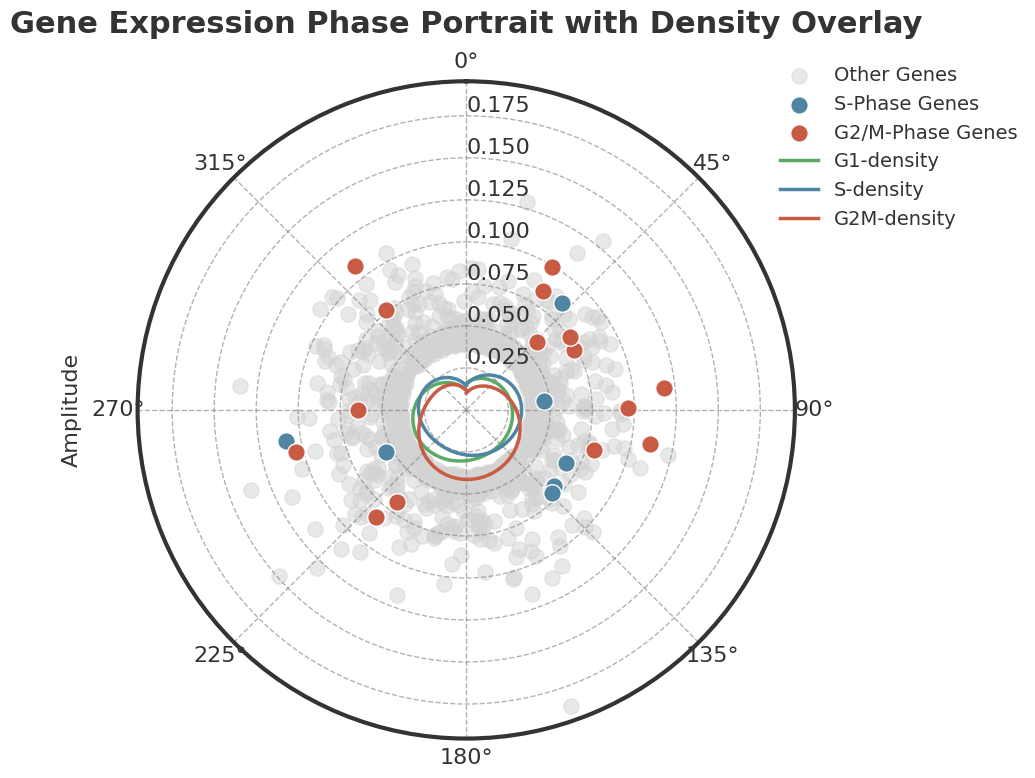

Plot saved to: ./FigurePlot/Gene_Radar/Radar_mESC_random.png


In [5]:
# --- Import required packages ---
import os
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Set working directory ---
# Change the current working directory to the project folder
os.chdir("/root/Cycle/Github")

# Print the current working directory to confirm
print("Current working directory:", os.getcwd())

# --- Add HarmoCycle module path ---
# Append the HarmoCycle module path so Python can find custom functions
sys.path.append("./HarmoCycle/")

# --- Import functions from HarmoCycle and Utils ---
from HarmoCycle import *
from Utils import set_seed, calculate_gene_oscillation_properties_v2

# --- Set random seed for reproducibility ---
set_seed(79710)

# --- Load dataset ---
adata1 = sc.read('./Dataset/mESC.h5ad')

# --- Preprocessing ---
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata1, target_sum=1e4)

# Apply log-transformation to stabilize variance
sc.pp.log1p(adata1)

# Shuffle cells randomly
adata1 = adata1[np.random.permutation(adata1.n_obs), :]

# --- Run HarmoCycle pipeline ---
_, _, adata_res1 = run_pipeline(
    adata1,
    epochs=2000,
    batch_size=1024,
    top_n_genes=5000,
    device='cuda:1'
)

# Sort cells by pseudo-angle
adata1 = adata1[adata1.obs['pseudo_angle'].sort_values().index, :]

# --- Extract periodic matrix ---
periodic_adata = get_periodic_matrix(adata1.copy(), top_k=10, use_highly_variable=True)

# --- Calculate PCA-based angle adjustment ---
adjust_adata1 = calculate_pca_angle(
    periodic_adata,
    use_rep='X',
    pca_key_added='X_pca_adjust',
    angle_key_added='pca_adjust_angle',
    plot=True
)

# Sort cells by adjusted PCA angle
adjust_adata1 = adjust_adata1[adjust_adata1.obs.sort_values(by='pca_adjust_angle').index, :]

# --- Calculate gene oscillation properties ---
adjust_adata1 = adjust_adata1[np.random.permutation(adjust_adata1.n_obs), :]
adjust_adata1 = calculate_gene_oscillation_properties_v2(adjust_adata1)
adata1 = adjust_adata1.copy()

# --- Select dominant frequency bin and sort genes by amplitude ---
# adata1 = adata1[:, adata1.var['dominant_frequency_bin'].isin(
#     adata1.var['dominant_frequency_bin'].value_counts().index[:1]
# )]
adata1 = adata1[:, adata1.var.sort_values('dominant_amplitude', ascending=False).index]

# Keep top 1000 genes
temp_res = adata1.var.head(1000).copy()
temp_res.sort_values('dominant_phase_deg', ascending=False, inplace=True)

# --- Load S-phase and G2/M-phase gene lists ---
s_genes = pd.read_table('./Dataset/Seurat_s_genes.csv')['x'].values
g2m_genes = pd.read_table('./Dataset/Seurat_g2m_genes.csv')['x'].values

# Filter genes present in temp_res
s_genes_in_temp_res = [gene for gene in s_genes if gene in temp_res.index]
g2m_genes_in_temp_res = [gene for gene in g2m_genes if gene in temp_res.index]

# --- Step 1: Compute median expression per stage ---
# Stage labels: 0 = G1, 1 = S, 2 = G2M
stage_labels = adata1.obs['stage']
stage_matrix = pd.DataFrame(adata1.X.toarray(), columns=adata1.var_names, index=adata1.obs_names)

stage_means = {
    'G1': stage_matrix[stage_labels == 0].median(axis=0),
    'S': stage_matrix[stage_labels == 1].median(axis=0),
    'G2M': stage_matrix[stage_labels == 2].median(axis=0),
}
stage_means_df = pd.DataFrame(stage_means)

# --- Step 2: Assign dominant stage with threshold ---
min_margin = 0.2  # Threshold: top stage must exceed second stage by at least 20%

def get_dominant_stage_with_threshold(row):
    sorted_vals = row.sort_values(ascending=False)
    top1 = sorted_vals.iloc[0]
    top2 = sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

stage_means_df['dominant_stage'] = stage_means_df.apply(get_dominant_stage_with_threshold, axis=1)

# --- Define colors for visualization ---
color_g1 = "#5DAA68"   # Green for G1 phase
color_s = "#4F85A2"    # Blue for S phase
color_g2m = "#C85B43"  # Red for G2/M phase
color_other = "#D3D3D3" # Grey for other genes
color_text = "#333333" # Dark text color

# --- Compute mean expression per stage ---
mean_expr = {
    'G1': stage_matrix[stage_labels == 0].mean(axis=0),
    'S': stage_matrix[stage_labels == 1].mean(axis=0),
    'G2M': stage_matrix[stage_labels == 2].mean(axis=0),
}
mean_expr_df = pd.DataFrame(mean_expr)

# Assign dominant stage with margin
def get_dominant_stage_with_margin(row):
    sorted_vals = row.sort_values(ascending=False)
    top1, top2 = sorted_vals.iloc[0], sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

mean_expr_df['dominant_stage'] = mean_expr_df.apply(get_dominant_stage_with_margin, axis=1)

# Merge dominant stage info into temp_res
temp_res['dominant_stage'] = mean_expr_df.loc[temp_res.index, 'dominant_stage']

# --- Convert dominant phase degrees to radians ---
def get_phase_radians(stage_name):
    degrees = temp_res[temp_res['dominant_stage'] == stage_name]['dominant_phase_deg'].values
    return np.deg2rad(degrees)

# Extract radians for each stage
g1_radians = get_phase_radians('G1')
s_radians = get_phase_radians('S')
g2m_radians = get_phase_radians('G2M')

# --- Kernel Density Estimation (KDE) ---
def smooth_density(data, num_points=512):
    if len(data) < 2:
        return np.linspace(0, 2*np.pi, num_points), np.zeros(num_points)
    kde = gaussian_kde(data, bw_method='scott')
    theta = np.linspace(0, 2*np.pi, num_points)
    density = kde(theta)
    return theta, density

theta_g1, density_g1 = smooth_density(g1_radians)
theta_s, density_s = smooth_density(s_radians)
theta_g2m, density_g2m = smooth_density(g2m_radians)

# --- Create polar plot ---
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# --- Scatter plot of gene phases and amplitudes ---
all_phases_deg = temp_res['dominant_phase_deg']
all_amplitudes = temp_res['dominant_amplitude']
s_data = temp_res.loc[s_genes_in_temp_res]
g2m_data = temp_res.loc[g2m_genes_in_temp_res]

all_phases_rad = np.deg2rad(all_phases_deg)
s_phases_rad = np.deg2rad(s_data['dominant_phase_deg'])
s_amplitudes = s_data['dominant_amplitude']
g2m_phases_rad = np.deg2rad(g2m_data['dominant_phase_deg'])
g2m_amplitudes = g2m_data['dominant_amplitude']

# Plot other genes
ax.scatter(all_phases_rad, all_amplitudes, c=color_other, alpha=0.5, s=120, label='Other Genes', zorder=1)

# Plot S-phase genes
ax.scatter(s_phases_rad, s_amplitudes, c=color_s, s=160, ec='w', lw=1.0, label='S-Phase Genes', zorder=3)

# Plot G2/M-phase genes
ax.scatter(g2m_phases_rad, g2m_amplitudes, c=color_g2m, s=160, ec='w', lw=1.0, label='G2/M-Phase Genes', zorder=3)

# --- Plot KDE density curves ---
ax.plot(theta_g1, density_g1 * max(all_amplitudes), color=color_g1, lw=2.5, label='G1-density', zorder=5)
ax.plot(theta_s, density_s * max(all_amplitudes), color=color_s, lw=2.5, label='S-density', zorder=5)
ax.plot(theta_g2m, density_g2m * max(all_amplitudes), color=color_g2m, lw=2.5, label='G2M-density', zorder=5)

# --- Finalize polar plot aesthetics ---
# Set the zero angle (0°) at the top (North)
ax.set_theta_zero_location('N')

# Set the direction of increasing angles clockwise
ax.set_theta_direction(-1)

# Add plot title
ax.set_title(
    'Gene Expression Phase Portrait with Density Overlay',
    fontsize=22,
    weight='bold',
    pad=35,
    color=color_text
)

# Adjust radial labels
ax.set_rlabel_position(0)
ax.tick_params(axis='y', labelsize=16, colors=color_text)
ax.tick_params(axis='x', labelsize=16, colors=color_text)

# Add radial axis label
ax.set_ylabel(
    'Amplitude',
    fontsize=16,
    labelpad=40,
    color=color_text,
    weight='medium'
)

# Customize polar spine
ax.spines['polar'].set_edgecolor(color_text)
ax.spines['polar'].set_linewidth(3)

# Add gridlines
ax.grid(True, linestyle='--', color='grey', alpha=0.6, linewidth=1)

# --- Add legend ---
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.95, 1.05),
    fontsize=14,
    frameon=False
)
for text in legend.get_texts():
    text.set_color(color_text)

# --- Save plot ---
# Define save path
save_path = './FigurePlot/Gene_Radar/Radar_mESC_random.png'

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure with high resolution
plt.tight_layout(pad=1.5)
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

# Print confirmation message
print(f"Plot saved to: {save_path}")



# hESC-Gene Phase Random

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 0.4440
Epoch 50/2000, Loss: 0.2197
Epoch 100/2000, Loss: 0.2161
Epoch 150/2000, Loss: 0.2129
Epoch 200/2000, Loss: 0.2100
Epoch 250/2000, Loss: 0.2074
Epoch 300/2000, Loss: 0.2052
Epoch 350/2000, Loss: 0.2038
Epoch 400/2000, Loss: 0.2021
Epoch 450/2000, Loss: 0.2008
Epoch 500/2000, Loss: 0.1992
Epoch 550/2000, Loss: 0.1978
Epoch 600/2000, Loss: 0.1968
Epoch 650/2000, Loss: 0.1955
Epoch 700/2000, Loss: 0.1947
Epoch 750/2000, Loss: 0.1937
Epoch 800/2000, Loss: 0.1930
Epoch 850/2000, Loss: 0.1921
Epoch 900/2000, Loss: 0.1914
Epoch 950/2000, Loss: 0.1908
Epoch 1000/2000, Loss: 0.1902
Epoch 1050/2000, Loss: 0.1896
Epoch 1100/2000, Loss: 0.1890
Epoch 1150/2000, Loss: 0.1886
Epoch 1200/2000, Loss: 0.1881
Epoch 1250/2000, Loss: 0.1874
Epoch 1300/2000, Loss: 0.1871
Epoch 1350/2000, Loss: 0.1864
Epoch 1400/2000, Loss: 0.1859
Epoch 1450/2000, Loss: 0.1855
Epoch 1500/2000, Loss: 0.1849
Epoch 1550/2000, Loss: 0.1849
Epoch 1600/2000, 

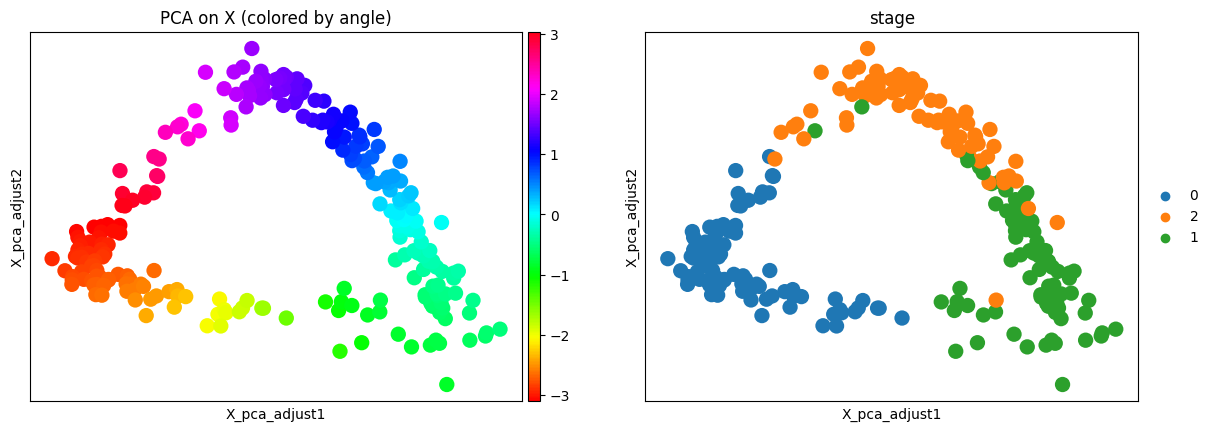

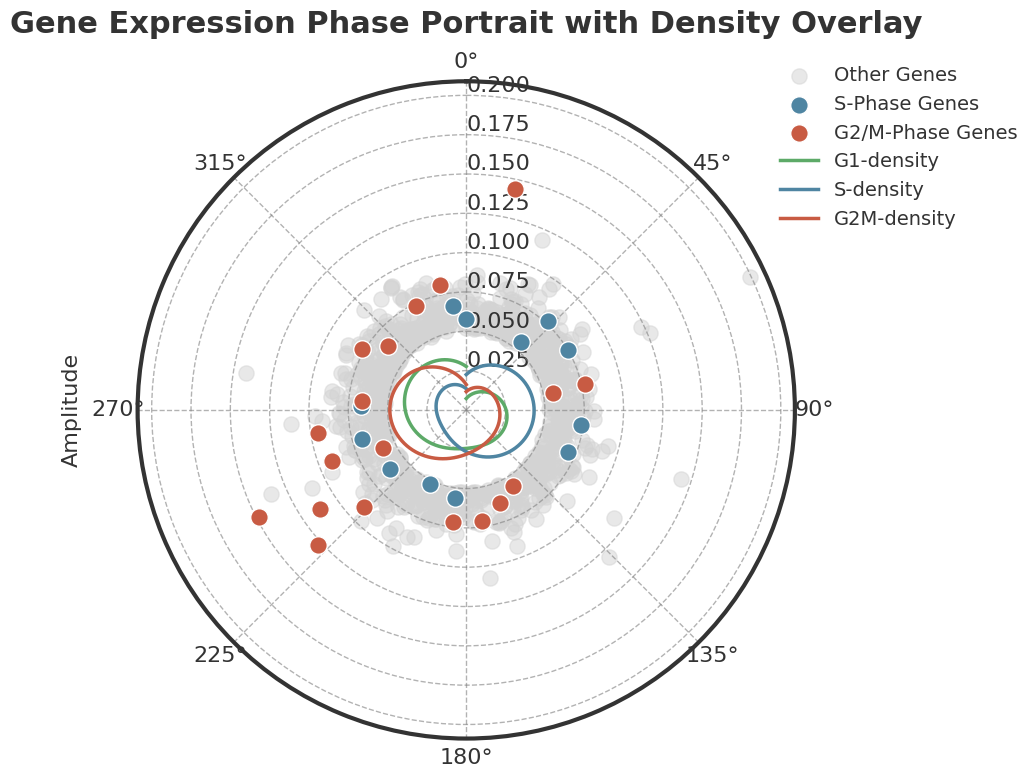

Plot saved to: ./FigurePlot/Gene_Radar/Radar_hESC_random.png


In [6]:
# --- Import required packages ---
import os
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Set working directory ---
# Change the current working directory to the project folder
os.chdir("/root/Cycle/Github")

# Print the current working directory to confirm
print("Current working directory:", os.getcwd())

# --- Add HarmoCycle module path ---
# Append the HarmoCycle module path so Python can find custom functions
sys.path.append("./HarmoCycle/")

# --- Import functions from HarmoCycle and Utils ---
from HarmoCycle import *
from Utils import set_seed, calculate_gene_oscillation_properties_v2

# --- Set random seed for reproducibility ---
set_seed(79710)

# --- Load dataset ---
adata1 = sc.read('./Dataset/hESC.h5ad')

# --- Preprocessing ---
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata1, target_sum=1e4)

# Apply log-transformation to stabilize variance
sc.pp.log1p(adata1)

# Shuffle cells randomly
adata1 = adata1[np.random.permutation(adata1.n_obs), :]

# --- Run HarmoCycle pipeline ---
_, _, adata_res1 = run_pipeline(
    adata1,
    epochs=2000,
    batch_size=1024,
    top_n_genes=5000,
    device='cuda:1'
)

# Sort cells by pseudo-angle
adata1 = adata1[adata1.obs['pseudo_angle'].sort_values().index, :]

# --- Extract periodic matrix ---
periodic_adata = get_periodic_matrix(adata1.copy(), top_k=10, use_highly_variable=True)

# --- Calculate PCA-based angle adjustment ---
adjust_adata1 = calculate_pca_angle(
    periodic_adata,
    use_rep='X',
    pca_key_added='X_pca_adjust',
    angle_key_added='pca_adjust_angle',
    plot=True
)

# Sort cells by adjusted PCA angle
adjust_adata1 = adjust_adata1[adjust_adata1.obs.sort_values(by='pca_adjust_angle').index, :]

# --- Calculate gene oscillation properties ---
adjust_adata1 = adjust_adata1[np.random.permutation(adjust_adata1.n_obs), :]
adjust_adata1 = calculate_gene_oscillation_properties_v2(adjust_adata1)
adata1 = adjust_adata1.copy()

# --- Select dominant frequency bin and sort genes by amplitude ---
# adata1 = adata1[:, adata1.var['dominant_frequency_bin'].isin(
#     adata1.var['dominant_frequency_bin'].value_counts().index[:1]
# )]
adata1 = adata1[:, adata1.var.sort_values('dominant_amplitude', ascending=False).index]

# Keep top 1000 genes
temp_res = adata1.var.head(1000).copy()
temp_res.sort_values('dominant_phase_deg', ascending=False, inplace=True)

# --- Load S-phase and G2/M-phase gene lists ---
s_genes = pd.read_table('./Dataset/Seurat_s_genes.csv')['x'].values
g2m_genes = pd.read_table('./Dataset/Seurat_g2m_genes.csv')['x'].values

# Filter genes present in temp_res
s_genes_in_temp_res = [gene for gene in s_genes if gene in temp_res.index]
g2m_genes_in_temp_res = [gene for gene in g2m_genes if gene in temp_res.index]

# --- Step 1: Compute median expression per stage ---
# Stage labels: 0 = G1, 1 = S, 2 = G2M
stage_labels = adata1.obs['stage']
stage_matrix = pd.DataFrame(adata1.X.toarray(), columns=adata1.var_names, index=adata1.obs_names)

stage_means = {
    'G1': stage_matrix[stage_labels == 0].median(axis=0),
    'S': stage_matrix[stage_labels == 1].median(axis=0),
    'G2M': stage_matrix[stage_labels == 2].median(axis=0),
}
stage_means_df = pd.DataFrame(stage_means)

# --- Step 2: Assign dominant stage with threshold ---
min_margin = 0.2  # Threshold: top stage must exceed second stage by at least 20%

def get_dominant_stage_with_threshold(row):
    sorted_vals = row.sort_values(ascending=False)
    top1 = sorted_vals.iloc[0]
    top2 = sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

stage_means_df['dominant_stage'] = stage_means_df.apply(get_dominant_stage_with_threshold, axis=1)

# --- Define colors for visualization ---
color_g1 = "#5DAA68"   # Green for G1 phase
color_s = "#4F85A2"    # Blue for S phase
color_g2m = "#C85B43"  # Red for G2/M phase
color_other = "#D3D3D3" # Grey for other genes
color_text = "#333333" # Dark text color

# --- Compute mean expression per stage ---
mean_expr = {
    'G1': stage_matrix[stage_labels == 0].mean(axis=0),
    'S': stage_matrix[stage_labels == 1].mean(axis=0),
    'G2M': stage_matrix[stage_labels == 2].mean(axis=0),
}
mean_expr_df = pd.DataFrame(mean_expr)

# Assign dominant stage with margin
def get_dominant_stage_with_margin(row):
    sorted_vals = row.sort_values(ascending=False)
    top1, top2 = sorted_vals.iloc[0], sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

mean_expr_df['dominant_stage'] = mean_expr_df.apply(get_dominant_stage_with_margin, axis=1)

# Merge dominant stage info into temp_res
temp_res['dominant_stage'] = mean_expr_df.loc[temp_res.index, 'dominant_stage']

# --- Convert dominant phase degrees to radians ---
def get_phase_radians(stage_name):
    degrees = temp_res[temp_res['dominant_stage'] == stage_name]['dominant_phase_deg'].values
    return np.deg2rad(degrees)

# Extract radians for each stage
g1_radians = get_phase_radians('G1')
s_radians = get_phase_radians('S')
g2m_radians = get_phase_radians('G2M')

# --- Kernel Density Estimation (KDE) ---
def smooth_density(data, num_points=512):
    if len(data) < 2:
        return np.linspace(0, 2*np.pi, num_points), np.zeros(num_points)
    kde = gaussian_kde(data, bw_method='scott')
    theta = np.linspace(0, 2*np.pi, num_points)
    density = kde(theta)
    return theta, density

theta_g1, density_g1 = smooth_density(g1_radians)
theta_s, density_s = smooth_density(s_radians)
theta_g2m, density_g2m = smooth_density(g2m_radians)

# --- Create polar plot ---
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# --- Scatter plot of gene phases and amplitudes ---
all_phases_deg = temp_res['dominant_phase_deg']
all_amplitudes = temp_res['dominant_amplitude']
s_data = temp_res.loc[s_genes_in_temp_res]
g2m_data = temp_res.loc[g2m_genes_in_temp_res]

all_phases_rad = np.deg2rad(all_phases_deg)
s_phases_rad = np.deg2rad(s_data['dominant_phase_deg'])
s_amplitudes = s_data['dominant_amplitude']
g2m_phases_rad = np.deg2rad(g2m_data['dominant_phase_deg'])
g2m_amplitudes = g2m_data['dominant_amplitude']

# Plot other genes
ax.scatter(all_phases_rad, all_amplitudes, c=color_other, alpha=0.5, s=120, label='Other Genes', zorder=1)

# Plot S-phase genes
ax.scatter(s_phases_rad, s_amplitudes, c=color_s, s=160, ec='w', lw=1.0, label='S-Phase Genes', zorder=3)

# Plot G2/M-phase genes
ax.scatter(g2m_phases_rad, g2m_amplitudes, c=color_g2m, s=160, ec='w', lw=1.0, label='G2/M-Phase Genes', zorder=3)

# --- Plot KDE density curves ---
ax.plot(theta_g1, density_g1 * max(all_amplitudes), color=color_g1, lw=2.5, label='G1-density', zorder=5)
ax.plot(theta_s, density_s * max(all_amplitudes), color=color_s, lw=2.5, label='S-density', zorder=5)
ax.plot(theta_g2m, density_g2m * max(all_amplitudes), color=color_g2m, lw=2.5, label='G2M-density', zorder=5)

# --- Finalize polar plot aesthetics ---
# Set the zero angle (0°) at the top (North)
ax.set_theta_zero_location('N')

# Set the direction of increasing angles clockwise
ax.set_theta_direction(-1)

# Add plot title
ax.set_title(
    'Gene Expression Phase Portrait with Density Overlay',
    fontsize=22,
    weight='bold',
    pad=35,
    color=color_text
)

# Adjust radial labels
ax.set_rlabel_position(0)
ax.tick_params(axis='y', labelsize=16, colors=color_text)
ax.tick_params(axis='x', labelsize=16, colors=color_text)

# Add radial axis label
ax.set_ylabel(
    'Amplitude',
    fontsize=16,
    labelpad=40,
    color=color_text,
    weight='medium'
)

# Customize polar spine
ax.spines['polar'].set_edgecolor(color_text)
ax.spines['polar'].set_linewidth(3)

# Add gridlines
ax.grid(True, linestyle='--', color='grey', alpha=0.6, linewidth=1)

# --- Add legend ---
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.95, 1.05),
    fontsize=14,
    frameon=False
)
for text in legend.get_texts():
    text.set_color(color_text)

# --- Save plot ---
# Define save path
save_path = './FigurePlot/Gene_Radar/Radar_hESC_random.png'

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure with high resolution
plt.tight_layout(pad=1.5)
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

# Print confirmation message
print(f"Plot saved to: {save_path}")



# hU2OS-Gene Phase Random

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 0.3488
Epoch 50/2000, Loss: 0.1887
Epoch 100/2000, Loss: 0.1874
Epoch 150/2000, Loss: 0.1876
Epoch 200/2000, Loss: 0.1853
Epoch 250/2000, Loss: 0.1849
Epoch 300/2000, Loss: 0.1856
Epoch 350/2000, Loss: 0.1846
Epoch 400/2000, Loss: 0.1850
Epoch 450/2000, Loss: 0.1843
Epoch 500/2000, Loss: 0.1849
Epoch 550/2000, Loss: 0.1844
Epoch 600/2000, Loss: 0.1840
Epoch 650/2000, Loss: 0.1846
Epoch 700/2000, Loss: 0.1823
Epoch 750/2000, Loss: 0.1844
Epoch 800/2000, Loss: 0.1842
Epoch 850/2000, Loss: 0.1835
Epoch 900/2000, Loss: 0.1842
Epoch 950/2000, Loss: 0.1834
Epoch 1000/2000, Loss: 0.1838
Epoch 1050/2000, Loss: 0.1835
Epoch 1100/2000, Loss: 0.1833
Epoch 1150/2000, Loss: 0.1833
Epoch 1200/2000, Loss: 0.1826
Epoch 1250/2000, Loss: 0.1810
Epoch 1300/2000, Loss: 0.1820
Epoch 1350/2000, Loss: 0.1809
Epoch 1400/2000, Loss: 0.1824
Epoch 1450/2000, Loss: 0.1839
Epoch 1500/2000, Loss: 0.1832
Epoch 1550/2000, Loss: 0.1808
Epoch 1600/2000, 

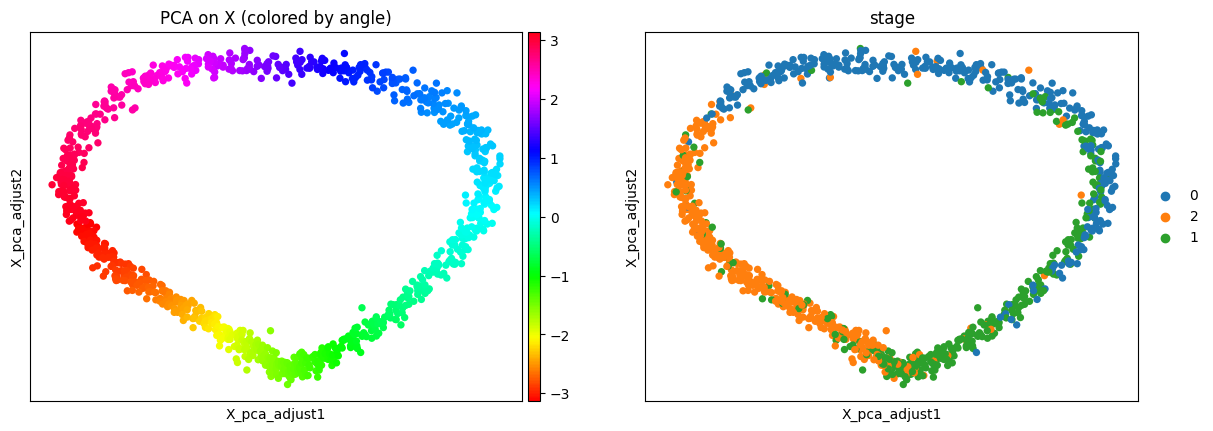

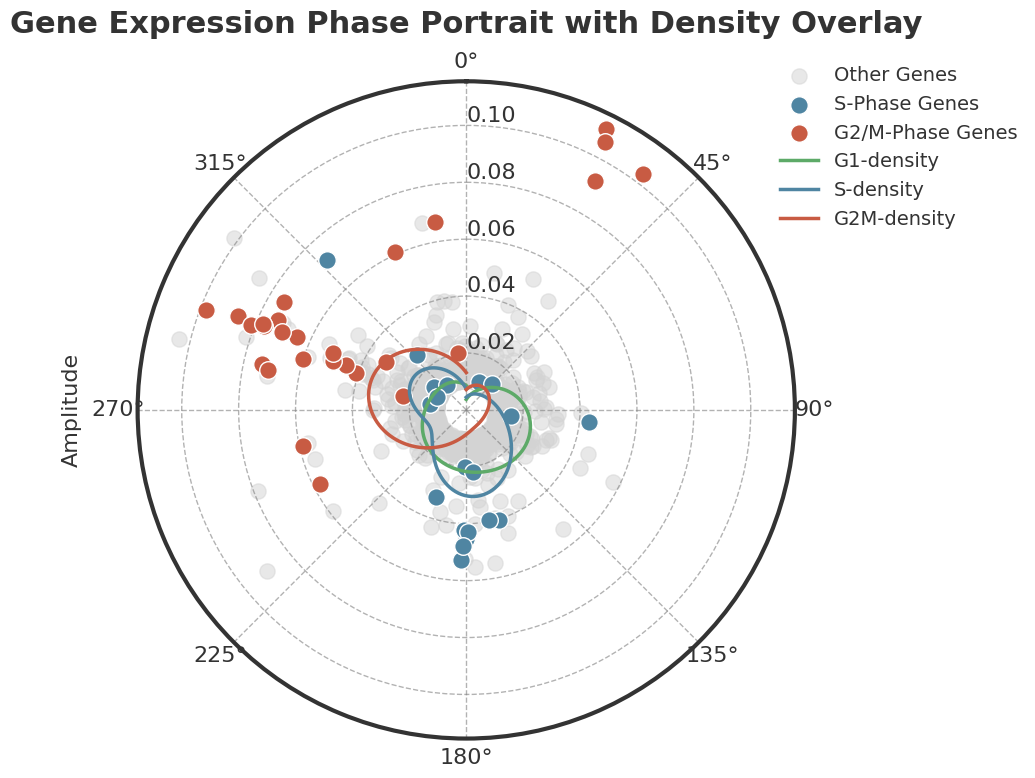

Plot saved to: ./FigurePlot/Gene_Radar/Radar_hU2OS_random.png


In [7]:
# --- Import required packages ---
import os
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Set working directory ---
# Change the current working directory to the project folder
os.chdir("/root/Cycle/Github")

# Print the current working directory to confirm
print("Current working directory:", os.getcwd())

# --- Add HarmoCycle module path ---
# Append the HarmoCycle module path so Python can find custom functions
sys.path.append("./HarmoCycle/")

# --- Import functions from HarmoCycle and Utils ---
from HarmoCycle import *
from Utils import set_seed, calculate_gene_oscillation_properties_v2

# --- Set random seed for reproducibility ---
set_seed(79710)

# --- Load dataset ---
adata1 = sc.read('./Dataset/hU2OS.h5ad')

# --- Preprocessing ---
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata1, target_sum=1e4)

# Apply log-transformation to stabilize variance
sc.pp.log1p(adata1)

# Shuffle cells randomly
adata1 = adata1[np.random.permutation(adata1.n_obs), :]

# --- Run HarmoCycle pipeline ---
_, _, adata_res1 = run_pipeline(
    adata1,
    epochs=2000,
    batch_size=1024,
    top_n_genes=5000,
    device='cuda:1'
)

# Sort cells by pseudo-angle
adata1 = adata1[adata1.obs['pseudo_angle'].sort_values().index, :]

# --- Extract periodic matrix ---
periodic_adata = get_periodic_matrix(adata1.copy(), top_k=10, use_highly_variable=True)

# --- Calculate PCA-based angle adjustment ---
adjust_adata1 = calculate_pca_angle(
    periodic_adata,
    use_rep='X',
    pca_key_added='X_pca_adjust',
    angle_key_added='pca_adjust_angle',
    plot=True
)

# Sort cells by adjusted PCA angle
adjust_adata1 = adjust_adata1[adjust_adata1.obs.sort_values(by='pca_adjust_angle').index, :]

# --- Calculate gene oscillation properties ---
adjust_adata1 = adjust_adata1[np.random.permutation(adjust_adata1.n_obs), :]
adjust_adata1 = calculate_gene_oscillation_properties_v2(adjust_adata1)
adata1 = adjust_adata1.copy()

# --- Select dominant frequency bin and sort genes by amplitude ---
# adata1 = adata1[:, adata1.var['dominant_frequency_bin'].isin(
#     adata1.var['dominant_frequency_bin'].value_counts().index[:1]
# )]
adata1 = adata1[:, adata1.var.sort_values('dominant_amplitude', ascending=False).index]

# Keep top 1000 genes
temp_res = adata1.var.head(1000).copy()
temp_res.sort_values('dominant_phase_deg', ascending=False, inplace=True)

# --- Load S-phase and G2/M-phase gene lists ---
s_genes = pd.read_table('./Dataset/Seurat_s_genes.csv')['x'].values
g2m_genes = pd.read_table('./Dataset/Seurat_g2m_genes.csv')['x'].values

# Filter genes present in temp_res
s_genes_in_temp_res = [gene for gene in s_genes if gene in temp_res.index]
g2m_genes_in_temp_res = [gene for gene in g2m_genes if gene in temp_res.index]

# --- Step 1: Compute median expression per stage ---
# Stage labels: 0 = G1, 1 = S, 2 = G2M
stage_labels = adata1.obs['stage']
stage_matrix = pd.DataFrame(adata1.X.toarray(), columns=adata1.var_names, index=adata1.obs_names)

stage_means = {
    'G1': stage_matrix[stage_labels == 0].median(axis=0),
    'S': stage_matrix[stage_labels == 1].median(axis=0),
    'G2M': stage_matrix[stage_labels == 2].median(axis=0),
}
stage_means_df = pd.DataFrame(stage_means)

# --- Step 2: Assign dominant stage with threshold ---
min_margin = 0.2  # Threshold: top stage must exceed second stage by at least 20%

def get_dominant_stage_with_threshold(row):
    sorted_vals = row.sort_values(ascending=False)
    top1 = sorted_vals.iloc[0]
    top2 = sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

stage_means_df['dominant_stage'] = stage_means_df.apply(get_dominant_stage_with_threshold, axis=1)

# --- Define colors for visualization ---
color_g1 = "#5DAA68"   # Green for G1 phase
color_s = "#4F85A2"    # Blue for S phase
color_g2m = "#C85B43"  # Red for G2/M phase
color_other = "#D3D3D3" # Grey for other genes
color_text = "#333333" # Dark text color

# --- Compute mean expression per stage ---
mean_expr = {
    'G1': stage_matrix[stage_labels == 0].mean(axis=0),
    'S': stage_matrix[stage_labels == 1].mean(axis=0),
    'G2M': stage_matrix[stage_labels == 2].mean(axis=0),
}
mean_expr_df = pd.DataFrame(mean_expr)

# Assign dominant stage with margin
def get_dominant_stage_with_margin(row):
    sorted_vals = row.sort_values(ascending=False)
    top1, top2 = sorted_vals.iloc[0], sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

mean_expr_df['dominant_stage'] = mean_expr_df.apply(get_dominant_stage_with_margin, axis=1)

# Merge dominant stage info into temp_res
temp_res['dominant_stage'] = mean_expr_df.loc[temp_res.index, 'dominant_stage']

# --- Convert dominant phase degrees to radians ---
def get_phase_radians(stage_name):
    degrees = temp_res[temp_res['dominant_stage'] == stage_name]['dominant_phase_deg'].values
    return np.deg2rad(degrees)

# Extract radians for each stage
g1_radians = get_phase_radians('G1')
s_radians = get_phase_radians('S')
g2m_radians = get_phase_radians('G2M')

# --- Kernel Density Estimation (KDE) ---
def smooth_density(data, num_points=512):
    if len(data) < 2:
        return np.linspace(0, 2*np.pi, num_points), np.zeros(num_points)
    kde = gaussian_kde(data, bw_method='scott')
    theta = np.linspace(0, 2*np.pi, num_points)
    density = kde(theta)
    return theta, density

theta_g1, density_g1 = smooth_density(g1_radians)
theta_s, density_s = smooth_density(s_radians)
theta_g2m, density_g2m = smooth_density(g2m_radians)

# --- Create polar plot ---
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# --- Scatter plot of gene phases and amplitudes ---
all_phases_deg = temp_res['dominant_phase_deg']
all_amplitudes = temp_res['dominant_amplitude']
s_data = temp_res.loc[s_genes_in_temp_res]
g2m_data = temp_res.loc[g2m_genes_in_temp_res]

all_phases_rad = np.deg2rad(all_phases_deg)
s_phases_rad = np.deg2rad(s_data['dominant_phase_deg'])
s_amplitudes = s_data['dominant_amplitude']
g2m_phases_rad = np.deg2rad(g2m_data['dominant_phase_deg'])
g2m_amplitudes = g2m_data['dominant_amplitude']

# Plot other genes
ax.scatter(all_phases_rad, all_amplitudes, c=color_other, alpha=0.5, s=120, label='Other Genes', zorder=1)

# Plot S-phase genes
ax.scatter(s_phases_rad, s_amplitudes, c=color_s, s=160, ec='w', lw=1.0, label='S-Phase Genes', zorder=3)

# Plot G2/M-phase genes
ax.scatter(g2m_phases_rad, g2m_amplitudes, c=color_g2m, s=160, ec='w', lw=1.0, label='G2/M-Phase Genes', zorder=3)

# --- Plot KDE density curves ---
ax.plot(theta_g1, density_g1 * max(all_amplitudes), color=color_g1, lw=2.5, label='G1-density', zorder=5)
ax.plot(theta_s, density_s * max(all_amplitudes), color=color_s, lw=2.5, label='S-density', zorder=5)
ax.plot(theta_g2m, density_g2m * max(all_amplitudes), color=color_g2m, lw=2.5, label='G2M-density', zorder=5)

# --- Finalize polar plot aesthetics ---
# Set the zero angle (0°) at the top (North)
ax.set_theta_zero_location('N')

# Set the direction of increasing angles clockwise
ax.set_theta_direction(-1)

# Add plot title
ax.set_title(
    'Gene Expression Phase Portrait with Density Overlay',
    fontsize=22,
    weight='bold',
    pad=35,
    color=color_text
)

# Adjust radial labels
ax.set_rlabel_position(0)
ax.tick_params(axis='y', labelsize=16, colors=color_text)
ax.tick_params(axis='x', labelsize=16, colors=color_text)

# Add radial axis label
ax.set_ylabel(
    'Amplitude',
    fontsize=16,
    labelpad=40,
    color=color_text,
    weight='medium'
)

# Customize polar spine
ax.spines['polar'].set_edgecolor(color_text)
ax.spines['polar'].set_linewidth(3)

# Add gridlines
ax.grid(True, linestyle='--', color='grey', alpha=0.6, linewidth=1)

# --- Add legend ---
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.95, 1.05),
    fontsize=14,
    frameon=False
)
for text in legend.get_texts():
    text.set_color(color_text)

# --- Save plot ---
# Define save path
save_path = './FigurePlot/Gene_Radar/Radar_hU2OS_random.png'

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure with high resolution
plt.tight_layout(pad=1.5)
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

# Print confirmation message
print(f"Plot saved to: {save_path}")



# mESCQ-Gene Phase Random

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 0.3900
Epoch 50/2000, Loss: 0.1966
Epoch 100/2000, Loss: 0.1906
Epoch 150/2000, Loss: 0.1849
Epoch 200/2000, Loss: 0.1790
Epoch 250/2000, Loss: 0.1754
Epoch 300/2000, Loss: 0.1727
Epoch 350/2000, Loss: 0.1698
Epoch 400/2000, Loss: 0.1679
Epoch 450/2000, Loss: 0.1660
Epoch 500/2000, Loss: 0.1647
Epoch 550/2000, Loss: 0.1636
Epoch 600/2000, Loss: 0.1637
Epoch 650/2000, Loss: 0.1635
Epoch 700/2000, Loss: 0.1629
Epoch 750/2000, Loss: 0.1630
Epoch 800/2000, Loss: 0.1629
Epoch 850/2000, Loss: 0.1630
Epoch 900/2000, Loss: 0.1628
Epoch 950/2000, Loss: 0.1629
Epoch 1000/2000, Loss: 0.1627
Epoch 1050/2000, Loss: 0.1629
Epoch 1100/2000, Loss: 0.1628
Epoch 1150/2000, Loss: 0.1628
Epoch 1200/2000, Loss: 0.1627
Epoch 1250/2000, Loss: 0.1628
Epoch 1300/2000, Loss: 0.1629
Epoch 1350/2000, Loss: 0.1628
Epoch 1400/2000, Loss: 0.1627
Epoch 1450/2000, Loss: 0.1628
Epoch 1500/2000, Loss: 0.1627
Epoch 1550/2000, Loss: 0.1626
Epoch 1600/2000, 

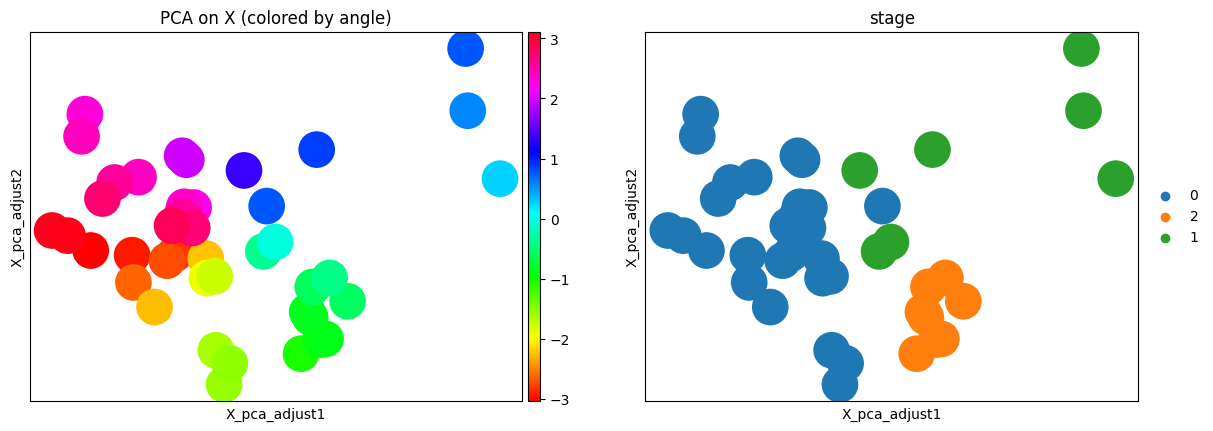

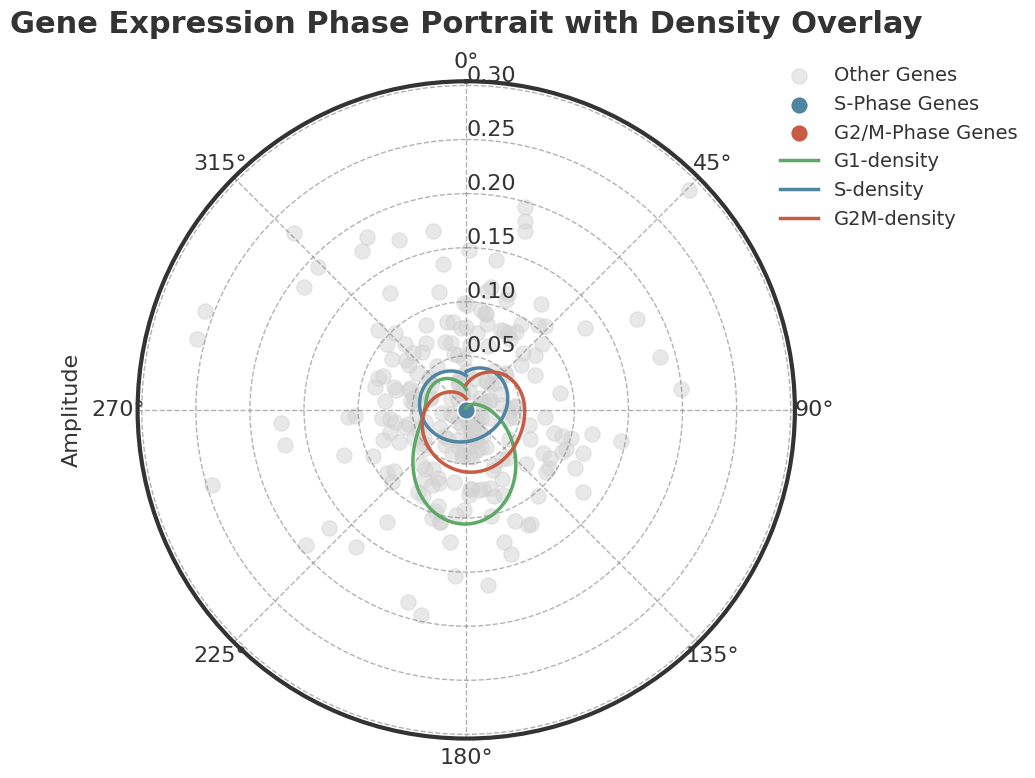

Plot saved to: ./FigurePlot/Gene_Radar/Radar_mESCQ_random.png


In [8]:
# --- Import required packages ---
import os
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Set working directory ---
# Change the current working directory to the project folder
os.chdir("/root/Cycle/Github")

# Print the current working directory to confirm
print("Current working directory:", os.getcwd())

# --- Add HarmoCycle module path ---
# Append the HarmoCycle module path so Python can find custom functions
sys.path.append("./HarmoCycle/")

# --- Import functions from HarmoCycle and Utils ---
from HarmoCycle import *
from Utils import set_seed, calculate_gene_oscillation_properties_v2

# --- Set random seed for reproducibility ---
set_seed(79710)

# --- Load dataset ---
adata1 = sc.read('./Dataset/mESCQ.h5ad')

# --- Preprocessing ---
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata1, target_sum=1e4)

# Apply log-transformation to stabilize variance
sc.pp.log1p(adata1)

# Shuffle cells randomly
adata1 = adata1[np.random.permutation(adata1.n_obs), :]

# --- Run HarmoCycle pipeline ---
_, _, adata_res1 = run_pipeline(
    adata1,
    epochs=2000,
    batch_size=1024,
    top_n_genes=5000,
    device='cuda:1'
)

# Sort cells by pseudo-angle
adata1 = adata1[adata1.obs['pseudo_angle'].sort_values().index, :]

# --- Extract periodic matrix ---
periodic_adata = get_periodic_matrix(adata1.copy(), top_k=10, use_highly_variable=True)

# --- Calculate PCA-based angle adjustment ---
adjust_adata1 = calculate_pca_angle(
    periodic_adata,
    use_rep='X',
    pca_key_added='X_pca_adjust',
    angle_key_added='pca_adjust_angle',
    plot=True
)

# Sort cells by adjusted PCA angle
adjust_adata1 = adjust_adata1[adjust_adata1.obs.sort_values(by='pca_adjust_angle').index, :]

# --- Calculate gene oscillation properties ---
adjust_adata1 = adjust_adata1[np.random.permutation(adjust_adata1.n_obs), :]
adjust_adata1 = calculate_gene_oscillation_properties_v2(adjust_adata1)
adata1 = adjust_adata1.copy()

# --- Select dominant frequency bin and sort genes by amplitude ---
adata1 = adata1[:, adata1.var['dominant_frequency_bin'].isin(
    adata1.var['dominant_frequency_bin'].value_counts().index[:1]
)]
adata1 = adata1[:, adata1.var.sort_values('dominant_amplitude', ascending=False).index]

# Keep top 1000 genes
temp_res = adata1.var.head(1000).copy()
temp_res.sort_values('dominant_phase_deg', ascending=False, inplace=True)

# --- Load S-phase and G2/M-phase gene lists ---
s_genes = pd.read_table('./Dataset/Seurat_s_genes.csv')['x'].values
g2m_genes = pd.read_table('./Dataset/Seurat_g2m_genes.csv')['x'].values

# Filter genes present in temp_res
s_genes_in_temp_res = [gene for gene in s_genes if gene in temp_res.index]
g2m_genes_in_temp_res = [gene for gene in g2m_genes if gene in temp_res.index]

# --- Step 1: Compute median expression per stage ---
# Stage labels: 0 = G1, 1 = S, 2 = G2M
stage_labels = adata1.obs['stage']
stage_matrix = pd.DataFrame(adata1.X.toarray(), columns=adata1.var_names, index=adata1.obs_names)

stage_means = {
    'G1': stage_matrix[stage_labels == 0].median(axis=0),
    'S': stage_matrix[stage_labels == 1].median(axis=0),
    'G2M': stage_matrix[stage_labels == 2].median(axis=0),
}
stage_means_df = pd.DataFrame(stage_means)

# --- Step 2: Assign dominant stage with threshold ---
min_margin = 0.2  # Threshold: top stage must exceed second stage by at least 20%

def get_dominant_stage_with_threshold(row):
    sorted_vals = row.sort_values(ascending=False)
    top1 = sorted_vals.iloc[0]
    top2 = sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

stage_means_df['dominant_stage'] = stage_means_df.apply(get_dominant_stage_with_threshold, axis=1)

# --- Define colors for visualization ---
color_g1 = "#5DAA68"   # Green for G1 phase
color_s = "#4F85A2"    # Blue for S phase
color_g2m = "#C85B43"  # Red for G2/M phase
color_other = "#D3D3D3" # Grey for other genes
color_text = "#333333" # Dark text color

# --- Compute mean expression per stage ---
mean_expr = {
    'G1': stage_matrix[stage_labels == 0].mean(axis=0),
    'S': stage_matrix[stage_labels == 1].mean(axis=0),
    'G2M': stage_matrix[stage_labels == 2].mean(axis=0),
}
mean_expr_df = pd.DataFrame(mean_expr)

# Assign dominant stage with margin
def get_dominant_stage_with_margin(row):
    sorted_vals = row.sort_values(ascending=False)
    top1, top2 = sorted_vals.iloc[0], sorted_vals.iloc[1]
    if (top1 - top2) / (top2 + 1e-6) >= min_margin:
        return sorted_vals.index[0]
    else:
        return 'Unclear'

mean_expr_df['dominant_stage'] = mean_expr_df.apply(get_dominant_stage_with_margin, axis=1)

# Merge dominant stage info into temp_res
temp_res['dominant_stage'] = mean_expr_df.loc[temp_res.index, 'dominant_stage']

# --- Convert dominant phase degrees to radians ---
def get_phase_radians(stage_name):
    degrees = temp_res[temp_res['dominant_stage'] == stage_name]['dominant_phase_deg'].values
    return np.deg2rad(degrees)

# Extract radians for each stage
g1_radians = get_phase_radians('G1')
s_radians = get_phase_radians('S')
g2m_radians = get_phase_radians('G2M')

# --- Kernel Density Estimation (KDE) ---
def smooth_density(data, num_points=512):
    if len(data) < 2:
        return np.linspace(0, 2*np.pi, num_points), np.zeros(num_points)
    kde = gaussian_kde(data, bw_method='scott')
    theta = np.linspace(0, 2*np.pi, num_points)
    density = kde(theta)
    return theta, density

theta_g1, density_g1 = smooth_density(g1_radians)
theta_s, density_s = smooth_density(s_radians)
theta_g2m, density_g2m = smooth_density(g2m_radians)

# --- Create polar plot ---
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# --- Scatter plot of gene phases and amplitudes ---
all_phases_deg = temp_res['dominant_phase_deg']
all_amplitudes = temp_res['dominant_amplitude']
s_data = temp_res.loc[s_genes_in_temp_res]
g2m_data = temp_res.loc[g2m_genes_in_temp_res]

all_phases_rad = np.deg2rad(all_phases_deg)
s_phases_rad = np.deg2rad(s_data['dominant_phase_deg'])
s_amplitudes = s_data['dominant_amplitude']
g2m_phases_rad = np.deg2rad(g2m_data['dominant_phase_deg'])
g2m_amplitudes = g2m_data['dominant_amplitude']

# Plot other genes
ax.scatter(all_phases_rad, all_amplitudes, c=color_other, alpha=0.5, s=120, label='Other Genes', zorder=1)

# Plot S-phase genes
ax.scatter(s_phases_rad, s_amplitudes, c=color_s, s=160, ec='w', lw=1.0, label='S-Phase Genes', zorder=3)

# Plot G2/M-phase genes
ax.scatter(g2m_phases_rad, g2m_amplitudes, c=color_g2m, s=160, ec='w', lw=1.0, label='G2/M-Phase Genes', zorder=3)

# --- Plot KDE density curves ---
ax.plot(theta_g1, density_g1 * max(all_amplitudes), color=color_g1, lw=2.5, label='G1-density', zorder=5)
ax.plot(theta_s, density_s * max(all_amplitudes), color=color_s, lw=2.5, label='S-density', zorder=5)
ax.plot(theta_g2m, density_g2m * max(all_amplitudes), color=color_g2m, lw=2.5, label='G2M-density', zorder=5)

# --- Finalize polar plot aesthetics ---
# Set the zero angle (0°) at the top (North)
ax.set_theta_zero_location('N')

# Set the direction of increasing angles clockwise
ax.set_theta_direction(-1)

# Add plot title
ax.set_title(
    'Gene Expression Phase Portrait with Density Overlay',
    fontsize=22,
    weight='bold',
    pad=35,
    color=color_text
)

# Adjust radial labels
ax.set_rlabel_position(0)
ax.tick_params(axis='y', labelsize=16, colors=color_text)
ax.tick_params(axis='x', labelsize=16, colors=color_text)

# Add radial axis label
ax.set_ylabel(
    'Amplitude',
    fontsize=16,
    labelpad=40,
    color=color_text,
    weight='medium'
)

# Customize polar spine
ax.spines['polar'].set_edgecolor(color_text)
ax.spines['polar'].set_linewidth(3)

# Add gridlines
ax.grid(True, linestyle='--', color='grey', alpha=0.6, linewidth=1)

# --- Add legend ---
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.95, 1.05),
    fontsize=14,
    frameon=False
)
for text in legend.get_texts():
    text.set_color(color_text)

# --- Save plot ---
# Define save path
save_path = './FigurePlot/Gene_Radar/Radar_mESCQ_random.png'

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure with high resolution
plt.tight_layout(pad=1.5)
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()

# Print confirmation message
print(f"Plot saved to: {save_path}")

